# Pest Counts in NH Corn Farms 

In [1]:
# Ram Gautam 
# University of New Hampshire
# Computer Science

In [2]:
import pandas as pd 
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [5]:
from scipy.interpolate import * 

In [6]:
%matplotlib inline

# 1. Multiple Linear Regression 

In [7]:
def Multiple_Linear_Regression(df_LinearRegression):
    #print (df_CEW_final.head())
    #print("Calling Multiple Linear Regression Modle")
    #print(sns.distplot(df_CEW_final['trap_count']))
    X_LR = df_LinearRegression[['tempf', 'dwpf', 'drct', 'feel']]
    y_LR = df_LinearRegression['trap_count']
    
    #splitting data into training and testing data
    X_train_lm, X_test_lm, y_train_lm,y_test_lm = train_test_split(X_LR,y_LR, test_size = 0.2, random_state = 101)
    #traing the data into the model
    regressionModel = LinearRegression()
    regressionModel.fit(X_train_lm, y_train_lm)
    
    #get the intercept
    print("Intercept: " , regressionModel.intercept_)
    
    #get the coeffecients
    print("Coeffecients " , regressionModel.coef_)
    
    #do the predictions - we need to pass the featuress that the model never seen before
    predictions = regressionModel.predict(X_test_lm)
    predictions_ret = regressionModel.predict(X_LR)
    print(predictions.shape)
    
    #print(y_test_lm)
    
    #cheking with the sctter plot 
    plt.scatter(y_test_lm , predictions)
    plt.savefig('linearRegression.png')
    
    print("----------- Linear Regression Evaluations------------")
    print("Mean Absolute Error (MAE): ", metrics.mean_absolute_error(y_test_lm , predictions))
    print("Mean Squared Eror (MSE): ", metrics.mean_squared_error(y_test_lm , predictions))
    print("Root Mean Squared Eror (RMSE): ", np.sqrt(metrics.mean_squared_error(y_test_lm , predictions)))
    
    #sns.distplot((y_test_lm - predictions))
    df_LinearRegression['regression_count'] = predictions_ret
    
    #converting into integer 
    df_LinearRegression['regression_count'] = df_LinearRegression['regression_count'].apply(np.int64)
    
    return df_LinearRegression


# 2. Poisson Regression

In [8]:
def Poisson_Regression(df_Poisson_Regression, pest, farm):
    
    equation = """trap_count ~ tempf + dwpf + drct + feel"""
    
    #setting up trainig and testing data set
    y_train, X_train = dmatrices(equation, df_Poisson_Regression, return_type='dataframe')
    y_test, X_test = dmatrices(equation, df_Poisson_Regression, return_type='dataframe')
    
    #setting up poission regression modle
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    
    #making the summary of Poisson Regression
    print(poisson_training_results.summary())
    
    #predictions of the rsults
    poisson_predictions = poisson_training_results.get_prediction(X_test)
    
    predictions_summary_frame = poisson_predictions.summary_frame()
    print(predictions_summary_frame)
    
    #the original count from the data frame 
    actual_counts = y_test['trap_count']
    
    #the predicted poission count
    poisson_count = predictions_summary_frame['mean']
    
    #computing RMSE
    print("Poisson Regression - RMSE: ", np.sqrt(metrics.mean_squared_error(actual_counts , poisson_count)))

    #making scatter plot here
    
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Poisson Regression Scatter plot' + pest + " on " + farm + "Farm")
    plt.scatter(x=poisson_count, y=actual_counts, marker='o')
    
    z = np.polyfit(poisson_count,actual_counts, 1)
    p = np.poly1d(z)
    plt.plot(poisson_count,p(poisson_count),"r--")

    plt.xlabel('Poisson counts')
    plt.ylabel('Actual counts')
    plt.savefig('Poisson'+ pest + farm + '.png')
    plt.show()
    
    #assigning the poission count here -- 
    farm = farm.strip()
    if farm == "all":
        df_Poisson_Regression['poisson_count'] = poisson_count
        df_Poisson_Regression['poisson_count'] = df_Poisson_Regression['poisson_count'].apply(np.int64)
    else:
        df_Poisson_Regression['poisson_count_farm'] = poisson_count
        df_Poisson_Regression['poisson_count_farm'] = df_Poisson_Regression['poisson_count_farm'].apply(np.int64)
    
    return df_Poisson_Regression
    

# 3. Negative Binomial Regression 

In [9]:
def Negative_Binomial_Regression(df_Negative_Binomial_Regression, pest, farm):
    
    if farm == "all":
        df_Negative_Binomial_Regression.drop('poisson_count', axis=1, inplace=True)
    
    equation = """trap_count ~ tempf + dwpf + drct + feel"""
    
    #setting up trainig and testing data set
    y_train, X_train = dmatrices(equation, df_Negative_Binomial_Regression, return_type='dataframe')
    y_test, X_test = dmatrices(equation, df_Negative_Binomial_Regression, return_type='dataframe')
    
    #setting up poission regression modle
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit(method="newton")
    
    #making the summary of Poisson Regression
    #print(poisson_training_results.summary())
    
    #predictions of the results
    poisson_predictions = poisson_training_results.get_prediction(X_test)
    predictions_summary_frame = poisson_predictions.summary_frame()
    #print(predictions_summary_frame)
    
    #adding lamda vector for negative binomial regression
    df_Negative_Binomial_Regression['LAMBDA'] = poisson_training_results.mu
    
    #adding dispersion value
    df_Negative_Binomial_Regression['AUX_OLS_DEP'] = df_Negative_Binomial_Regression.apply(lambda x: ((x['poisson_count'] - x['LAMBDA'])**2 - x['poisson_count']) / x['LAMBDA'], axis=1)

    #defining ols expression
    ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""
    
    #getting olsr results 
    aux_olsr_results = smf.ols(ols_expr, df_Negative_Binomial_Regression).fit()

    #defining negative binomial regression model 
    M2_NB = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha = abs(aux_olsr_results.params[0]))).fit()
    
    print(M2_NB.summary())
    
    M2_NB_pred = M2_NB.get_prediction(X_test)
    predictions_summary_frame = M2_NB_pred.summary_frame()
    
    print(predictions_summary_frame)
    
    #counts after negative binomial regression 
    NB_counts=predictions_summary_frame['mean']
    
    #actual counts 
    NB_actual_counts = y_test['trap_count']
    
    print("Negative Binomial - RMSE: ", np.sqrt(metrics.mean_squared_error(NB_actual_counts, NB_counts)))
    
    #making scatter plot here 
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Negative Binomial Regression Scatter plot' + pest + " on " + farm + "Farm")
    plt.scatter(x=NB_counts, y=NB_actual_counts, marker='x')
    
    z = np.polyfit(NB_counts,NB_actual_counts, 1)
    p = np.poly1d(z)
    plt.plot(NB_counts,p(NB_counts),"r--")
    
    plt.xlabel('Nehative Bionomial counts')
    plt.ylabel('Actual counts')
    plt.savefig('Negative Binomial '+ pest + farm + '.png')
    plt.show()
    
    #assigning the poission count here -- 
    #df_Negative_Binomial_Regression['NB_count_farm'] = NB_counts
    
    farm = farm.strip()
    if farm == "all":
        #df_Poisson_Regression['poisson_count'] = poisson_count
        df_Negative_Binomial_Regression['NB_count'] = NB_counts
        df_Negative_Binomial_Regression['NB_count'] = df_Negative_Binomial_Regression['NB_count'].apply(np.int64)

    else:
        #df_Poisson_Regression['poisson_count_farm'] = poisson_count
        df_Negative_Binomial_Regression['NB_count_farm'] = NB_counts
        df_Negative_Binomial_Regression['NB_count_farm'] = df_Negative_Binomial_Regression['NB_count_farm'].apply(np.int64)
        
    
    df_Negative_Binomial_Regression.drop('LAMBDA', axis=1, inplace=True)
    df_Negative_Binomial_Regression.drop('AUX_OLS_DEP', axis=1, inplace=True)
    
    return df_Negative_Binomial_Regression
    

In [10]:
#Reading the Original data frame
df = pd.read_csv('pest_traps.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

In [11]:
df.shape

(12434, 7)

# Bulding CEW DataFrame 

In [12]:
#dividing the dataframe based on each pests - pest CEW
df_CEW = df.loc[['CEW'], ['farm', 'trap_count','year','date']]

In [13]:
df_CEW.head()

,farm,trap_count,year,date
pest,,,,
CEW,Pelham-G,0,2006,20060619
CEW,Litchfield-W,0,2006,20060619
CEW,Litchfield-M,0,2006,20060619
CEW,Merrimack-T,0,2006,20060619
CEW,Hollis-L,1,2006,20060619


In [14]:
df_CEW.tail()

,farm,trap_count,year,date
pest,,,,
CEW,Hollis-K,3,2018,20181008
CEW,Hollis-B2,0,2018,20181008
CEW,Hollis-L,8,2018,20181008
CEW,Hollis-K,3,2018,20181015
CEW,Hollis-L,2,2018,20181015


In [15]:
df_CEW.shape

(3626, 4)

In [16]:
from datetime import date 

def compute_weeks(startDate, endDate):
    s_yyyy = str(startDate)[0:4]
    s_mm = str(startDate)[5:7]
    s_dd = str(startDate)[8:10]
            
    d1 = date(int(s_yyyy),int(s_mm),int(s_dd))
    
    e_yyyy = str(endDate)[0:4]
    e_mm = str(endDate)[5:7]
    e_dd = str(endDate)[8:10]
            
    d2 = date(int(e_yyyy),int(e_mm),int(e_dd))
    
    return (int((d2-d1).days / 7))
            
def convert_pandasDate(change_date):
    change_date = str(change_date)[:4] + "/" + str(change_date)[4:6] + "/" + str(change_date)[6:8]
    change_date = pd.to_datetime(change_date)
    return (change_date)
    

In [17]:
start_cew_date = df_CEW['date'].values[0]
search_cew_STdate = convert_pandasDate(start_cew_date)

end_cew_date = df_CEW['date'].values[3626-1]
search_cew_ENDdate = convert_pandasDate(end_cew_date)

df_CEW['date'] = df_CEW['date'].apply(convert_pandasDate)
#df_CEW['date'] = pd.to_datetime(df_CEW['date'])

print(search_cew_STdate)
print(search_cew_ENDdate)

print("total weeeks " , compute_weeks(search_cew_STdate, search_cew_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [18]:
df_CEW['date'] = pd.to_datetime(df_CEW['date'])

# Building ECB DataFrame  

In [19]:
#dividing the dataframe based on each pests - pest ECB
df_ECB = df.loc[['ECB'], ['farm', 'trap_count','year','date']]

In [20]:
df_ECB.head()

,farm,trap_count,year,date
pest,,,,
ECB,Litchfield-W,16,2006,20060619
ECB,Hollis-B,7,2006,20060619
ECB,Mason-B,11,2006,20060619
ECB,Litchfield-W,25,2006,20060626
ECB,Hollis-B,31,2006,20060626


In [21]:
df_ECB.tail()

,farm,trap_count,year,date
pest,,,,
ECB,Hollis-JL-Pl,0,2018,20180924
ECB,Peterborough-R,0,2018,20180924
ECB,Mason-B,0,2018,20180924
ECB,NewIpswich-B,0,2018,20180924
ECB,Milford-M,0,2018,20180924


In [22]:
df_ECB.shape

(4979, 4)

In [23]:
start_ecb_date = df_ECB['date'].values[0]
search_ecb_STdate = convert_pandasDate(start_cew_date)

end_ecb_date = df_ECB['date'].values[4979-1]
search_ecb_ENDdate = convert_pandasDate(end_cew_date)

df_ECB['date'] = df_ECB['date'].apply(convert_pandasDate)

print(search_ecb_STdate)
print(search_ecb_ENDdate)

print("total weeeks " , compute_weeks(search_ecb_STdate, search_ecb_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [24]:
df_ECB['date'] = pd.to_datetime(df_ECB['date'])

# Building FAW DataFrame

In [25]:
#dividing the dataframe based on each pests - pest FAW
df_FAW = df.loc[['FAW'], ['farm', 'trap_count','year','date']]

In [26]:
df_FAW.head()

,farm,trap_count,year,date
pest,,,,
FAW,Pelham-G,0,2006,20060619
FAW,Litchfield-W,0,2006,20060619
FAW,Litchfield-M,0,2006,20060619
FAW,Merrimack-T,0,2006,20060619
FAW,Hollis-L,0,2006,20060619


In [27]:
df_FAW.tail()

,farm,trap_count,year,date
pest,,,,
FAW,Antrim-T,0,2018,20181001
FAW,Milford-M,0,2018,20181001
FAW,Hollis-B2,0,2018,20181008
FAW,Hollis-L,2,2018,20181008
FAW,Hollis-L,3,2018,20181015


In [28]:
df_FAW.shape

(3829, 4)

In [29]:
start_faw_date = df_FAW['date'].values[0]
search_faw_STdate = convert_pandasDate(start_cew_date)

end_faw_date = df_FAW['date'].values[3829-1]
search_faw_ENDdate = convert_pandasDate(end_cew_date)

df_FAW['date'] = df_FAW['date'].apply(convert_pandasDate)

print(search_faw_STdate)
print(search_faw_ENDdate)

print("total weeeks " , compute_weeks(search_faw_STdate, search_faw_ENDdate))

2006-06-19 00:00:00
2018-10-15 00:00:00
total weeeks  643


In [30]:
df_FAW['date'] = pd.to_datetime(df_FAW['date'])

# NOAA DATA - Weather Data 

In [31]:
df_NOOA = pd.read_csv('DAW.csv', header=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,15,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
df_NOOA.shape

(473979, 29)

In [33]:
df_NOOA.head()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
0,DAW,1/1/06 0:38,24.80,10.40,53.75,60.0,3.0,NaN,29.90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.46,KDAW 010038Z AUTO 06003KT 10SM BKN029 OVC045 M...
1,DAW,1/1/06 0:51,24.08,10.04,54.51,80.0,3.0,NaN,29.90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.63,KDAW 010051Z AUTO 08003KT 10SM SCT029 BKN045 O...
2,DAW,1/1/06 1:51,21.92,15.98,77.54,20.0,6.0,NaN,29.89,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.39,KDAW 010151Z AUTO 02006KT 3SM -SN BKN022 BKN03...
3,DAW,1/1/06 2:15,21.20,17.60,85.74,30.0,7.0,NaN,29.88,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.61,KDAW 010215Z AUTO 03007KT 3SM -SN SCT026 BKN06...
4,DAW,1/1/06 2:51,21.92,17.06,81.25,30.0,6.0,NaN,29.88,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.39,KDAW 010251Z AUTO 03006KT 7SM -SN FEW055 OVC07...


In [34]:
df_NOOA.columns

Index(['station', 'valid', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i',
       'alti', 'mslp', 'vsby', 'gust', 'skyc1', 'skyc2', 'skyc3', 'skyc4',
       'skyl1', 'skyl2', 'skyl3', 'skyl4', 'wxcodes', 'ice_accretion_1hr',
       'ice_accretion_3hr', 'ice_accretion_6hr', 'peak_wind_gust',
       'peak_wind_drct', 'peak_wind_time', 'feel', 'metar'],
      dtype='object')

In [35]:
df_equation  = df_NOOA[['tmpf','dwpf', 'drct','feel', 'valid']]
df_equation.head()

,tmpf,dwpf,drct,feel,valid
0,24.80,10.40,60.0,20.46,1/1/06 0:38
1,24.08,10.04,80.0,19.63,1/1/06 0:51
2,21.92,15.98,20.0,13.39,1/1/06 1:51
3,21.20,17.60,30.0,11.61,1/1/06 2:15
4,21.92,17.06,30.0,13.39,1/1/06 2:51


In [36]:
df_equation['valid'] = pd.to_datetime(df_equation['valid'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
print(search_cew_STdate)
print(search_cew_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


# selecting weather dataframe within the date range - CEW Pest

In [38]:
#selecting the dataframe within the range - CEW Pest
#df_equation = df_equation.loc[(df_equation['valid'] >= search_st_date) & (df_equation['valid'] <= search_end_date), :]
df_equation = df_equation.loc[(df_equation['valid'] >= search_cew_STdate) & (df_equation['valid'] <= search_cew_ENDdate), :]

In [39]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf = df_equation[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf["tmpf"] = df_tempf["tmpf"].fillna(0)
df_tempf["dwpf"] = df_tempf["dwpf"].fillna(0)
df_tempf["drct"] = df_tempf["drct"].fillna(0)
df_tempf["feel"] = df_tempf["feel"].fillna(0)

In [40]:
df_tempf.tail()

,tmpf,dwpf,drct,feel,valid
341757,0.0,0.0,0.0,0.0,2018-10-14 23:35:00
341758,0.0,0.0,190.0,0.0,2018-10-14 23:40:00
341759,0.0,0.0,0.0,0.0,2018-10-14 23:50:00
341760,46.0,39.9,0.0,46.0,2018-10-14 23:51:00
341761,0.0,0.0,0.0,0.0,2018-10-14 23:55:00


In [41]:
#df_tempf

In [42]:
from datetime import date

def getweekly_temperature(df_tempf,CEW_weather_data_dic):
    
    week_counts = 0
    
    count = 0
    temp_index = 0
     
    count_day0 = 0
    count_day1 = 0
    count_day2 = 0
    count_day3 = 0
    count_day4 = 0
    count_day5 = 0
    count_day6= 0
    totaldays = 0
    
    temperature = 0
    dewTemp = 0
    winDir = 0
    feelTemp = 0
    
    #empt sets for all the values
    lst_tempf = []
    lst_dwpf = []
    lst_drct = []
    lst_feel = []
    lst_date = []
    
    for i , j in df_tempf.iterrows():
        
        if count ==0:
            row = (i,j)
            #print(row[1][1])
            #initial_date = row[1][1]
            initial_date = row[1][4]
            f_yyyy = str(initial_date)[0:4]
            f_mm = str(initial_date)[5:7]
            f_dd = str(initial_date)[8:10]
            f_date = date(int(f_yyyy),int(f_mm),int(f_dd))
            
        row_data = (i,j)
        #print(row_data)
        #summing up the temperature
        #temperature = row_data[1][0]
        temperature = temperature + row_data[1][0]
        dewTemp = dewTemp + row_data[1][1]
        winDir = winDir + row_data[1][2]
        feelTemp = feelTemp + row_data[1][3]
        
        #last_date = row_data[1][1]
        last_date = row_data[1][4]
        l_yyyy = str(last_date)[0:4]
        l_mm = str(last_date)[5:7]
        l_dd = str(last_date)[8:10]
        l_date = date(int(l_yyyy),int(l_mm),int(l_dd))
            
        #change in date 
        delta = l_date - f_date
        #print (delta.days)
        if delta.days%7 == 0:
            week_counts = week_counts + 1
        
        if delta.days == 0:
            count_day0 = count_day0 + 1
        elif delta.days == 1:
            count_day1 = count_day1 + 1
        elif delta.days == 2:
            count_day2 = count_day2 + 1
        elif delta.days == 3:
            count_day3 = count_day3 + 1
        elif delta.days == 4:
            count_day4 = count_day4 + 1
        elif delta.days == 5:
            count_day5 = count_day5 + 1
        elif delta.days == 6:
            count_day6 = count_day6 + 1       
        #elif delta.days == 7:
        else:
            #compute average temperature
            totaldays = count_day0 + count_day1 + count_day2 + count_day3 + count_day4 + count_day5 + count_day6
            
            avg_Temp = temperature/totaldays
            avg_dewTemp = dewTemp/totaldays
            avg_winDir = winDir/totaldays
            avg_feelTemp = feelTemp/totaldays
            
            #appending values to the list
            lst_tempf.append(avg_Temp)
            lst_dwpf.append(avg_dewTemp)
            lst_drct.append(avg_winDir)
            lst_feel.append(avg_feelTemp) 
    
            lst_date.append(f_date)
            #print(f_date)
            
            #get the start date 
            #put all into the date frame 
            
            temp_index = temp_index + 1
            
            #flush the date 
            f_date = l_date
            
            #flush days count 
            count_day0 = 0
            count_day1 = 0
            count_day2 = 0
            count_day3 = 0 
            count_day4 = 0 
            count_day5 = 0
            count_day6 = 0
            
            #flushing all the records ---- temperature
            temperature = 0
            dewTemp = 0
            winDir = 0
            feelTemp = 0
            
        #initialize the repetation
        count = count + 1
        
    print("total temperature index ", temp_index)
    print("total weeks: ", week_counts)
    
    #assigning list to the dictonary
    CEW_weather_data_dic['tempf'] = lst_tempf
    CEW_weather_data_dic['dwpf'] = lst_dwpf
    CEW_weather_data_dic['drct'] = lst_drct
    CEW_weather_data_dic['feel'] = lst_feel
    CEW_weather_data_dic['date'] = lst_date
    
    #return CEW_weather_data_dic
    #print(df_tempf)

In [43]:
#calling getweekly_temperature
CEW_weather_data_dic = {}
getweekly_temperature(df_tempf,CEW_weather_data_dic)

total temperature index  642
total weeks:  47922


In [44]:
#creating data frame needed for equation
#print(CEW_weather_data_dic)
df_CEW_weather = pd.DataFrame(CEW_weather_data_dic)

In [45]:
df_CEW_weather.head()

,tempf,dwpf,drct,feel,date
0,70.977613,63.913169,63.703704,71.301399,2006-06-19
1,71.243468,65.095887,84.233871,71.733347,2006-06-26
2,71.056485,59.203758,127.515152,71.263273,2006-07-03
3,71.830909,66.491782,59.745455,72.608255,2006-07-10
4,73.200175,66.515808,101.004367,74.150786,2006-07-17


In [46]:
df_CEW_weather.tail()

,tempf,dwpf,drct,feel,date
637,6.936188,6.288330,156.129550,6.983009,2018-09-03
638,9.211018,8.905188,113.670949,9.217243,2018-09-10
639,7.760753,7.281021,110.056730,7.728195,2018-09-17
640,6.692446,6.180576,161.330935,6.548972,2018-09-24
641,7.799536,7.509856,134.674923,7.750764,2018-10-01


In [47]:
df_CEW['date'] = df_CEW['date'].dt.date

In [48]:
df_CEW_weather['date'] = pd.to_datetime(df_CEW_weather['date'])

In [49]:
df_CEW_weather['date'] = df_CEW_weather['date'].dt.date

In [50]:
df_CEW_final = df_CEW.merge(df_CEW_weather, on='date')

# Pest Trap Predictions - CEW 

In [51]:
df_CEW_final.columns

Index(['farm', 'trap_count', 'year', 'date', 'tempf', 'dwpf', 'drct', 'feel'], dtype='object')

In [52]:
df_CEW_final.describe()

,trap_count,year,tempf,dwpf,drct,feel
count,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000
mean,11.255543,2011.277713,58.827690,51.541183,110.975810,58.778105
std,26.194937,3.426363,19.976941,17.552113,28.670125,20.108285
min,0.000000,2006.000000,6.525835,5.567537,42.116788,6.512886
25%,0.000000,2009.000000,57.839788,50.667614,91.898734,57.344561
50%,2.000000,2011.000000,66.117340,57.909561,108.623853,66.206620
75%,10.000000,2013.000000,70.330218,62.173632,128.214654,70.216494
max,313.000000,2018.000000,79.977751,68.505141,185.802469,81.125680


# 1. Multiple Linear Regression using all data

Intercept:  8.848344854621619
Coeffecients  [-0.71959129  0.03611909  0.02071853  0.68803956]
(515,)
----------- Linear Regression Evaluations------------
Mean Absolute Error (MAE):  14.705005947180688
Mean Squared Eror (MSE):  860.9897652483703
Root Mean Squared Eror (RMSE):  29.342627102022924


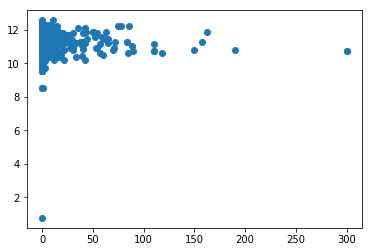

In [53]:
df_CEW_final = Multiple_Linear_Regression(df_CEW_final)

In [54]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10


# 2. Poisson Regression using all data 

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2571
Model:                            GLM   Df Residuals:                     2566
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41041.
Date:                Tue, 12 May 2020   Deviance:                       75750.
Time:                        20:20:02   Pearson chi2:                 1.55e+05
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2900      0.042     54.923      0.000       2.208       2.372
tempf         -0.0907      0.008    -12.012      0.0

<Figure size 432x288 with 0 Axes>

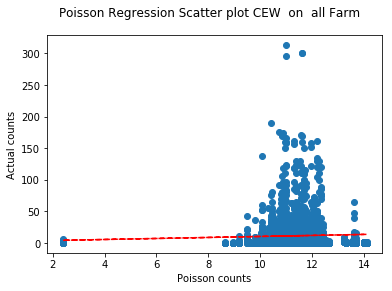

In [55]:
df_CEW_final = Poisson_Regression(df_CEW_final," CEW ", " all ")

# 3. Negative Binomial Regression using all data 

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2571
Model:                            GLM   Df Residuals:                     2566
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21422.
Date:                Tue, 12 May 2020   Deviance:                       35463.
Time:                        20:20:03   Pearson chi2:                 8.07e+04
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2547      0.058     38.913      0.000       2.141       2.368
tempf         -0.1137      0.010    -11.283      0.0

<Figure size 432x288 with 0 Axes>

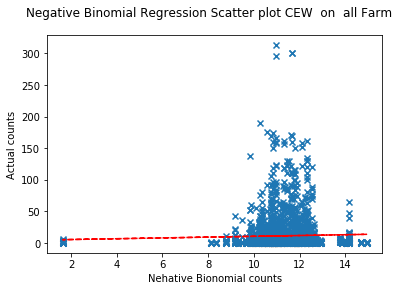

In [56]:
df_CEW_final = Negative_Binomial_Regression(df_CEW_final, " CEW ", " all ")

In [57]:
df_CEW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10


In [58]:
#selcting all the farms for the CEW pest
all_CEW_FARMS = df_CEW_final.farm.unique()

In [59]:
all_CEW_FARMS

array(['Pelham-G', 'Litchfield-W', 'Litchfield-M', 'Merrimack-T',
       'Hollis-L', 'Hollis-B', 'Hollis-K', 'Milford-S', 'Antrim-T',
       'Mason-B', 'Peterborough-R', 'Plainfield-E', 'Milford-L',
       'NorthHaverhill-B', 'Jaffrey-C', 'Hollis-JL', 'Hudson-S',
       'Litchfield-W1', 'Hollis-L1', 'Mason-B1', 'Merrimack-S',
       'Litchfield-W2', 'Mason-B2', 'Hollis-L2', 'Hollis-B1', 'Loudon-P',
       'Amherst-P', 'Concord-A', 'Concord-D2', 'Concord-P', 'Boscawen-C',
       'Weare-I', 'NewBoston-M', 'Concord-D1', 'NewLondon-S', 'Hollis-B2',
       'Loudon-P1', 'Loudon-P2', 'NewIpswich-B', 'Milford-M',
       'Bradford-W', 'NewLondon-SL', 'Hollis-JL-T', 'Claremont-TL',
       'Meredith-M', 'CenterConway-S', 'Hollis-JL-Pl', 'NewBoston-D',
       'Weare-D'], dtype=object)

In [60]:
all_CEW_FARMS.shape

(49,)

# Poisson Regression and Negative Binomial Regression for each individual farm 

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -821.31
Date:                Tue, 12 May 2020   Deviance:                       1433.0
Time:                        20:20:03   Pearson chi2:                 2.42e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0062      0.370     -2.719      0.007      -1.732      -0.281
tempf         -0.0256      0.040     -0.648      0.5

<Figure size 432x288 with 0 Axes>

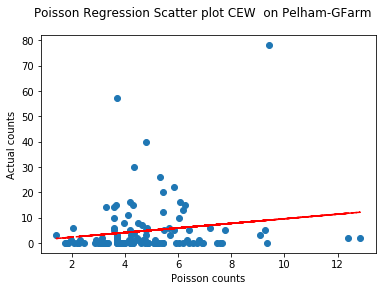

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -306.61
Date:                Tue, 12 May 2020   Deviance:                       279.85
Time:                        20:20:03   Pearson chi2:                     361.
No. Iterations:                    16   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1277      0.835     -1.350      0.177      -2.764       0.509
tempf         -0.0828      0.103     -0.802      0.4

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

<Figure size 432x288 with 0 Axes>

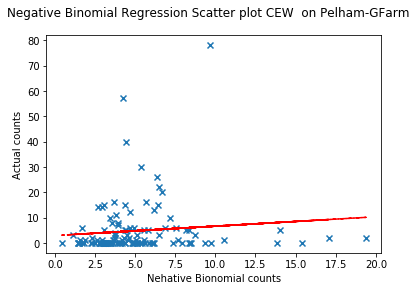

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   71
Model:                            GLM   Df Residuals:                       66
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1624.1
Date:                Tue, 12 May 2020   Deviance:                       2949.4
Time:                        20:20:04   Pearson chi2:                 3.27e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1329      0.262     31.007      0.000       7.619       8.647
tempf          0.0215      0.022      0.972      0.3

<Figure size 432x288 with 0 Axes>

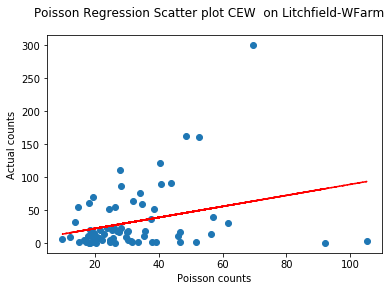

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   71
Model:                            GLM   Df Residuals:                       66
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -326.81
Date:                Tue, 12 May 2020   Deviance:                       198.70
Time:                        20:20:04   Pearson chi2:                     151.
No. Iterations:                    17   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8477      1.274      7.728      0.000       7.350      12.345
tempf         -0.0087      0.062     -0.140      0.8

<Figure size 432x288 with 0 Axes>

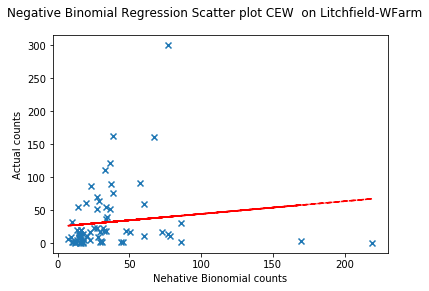

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  147
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2056.5
Date:                Tue, 12 May 2020   Deviance:                       3762.8
Time:                        20:20:05   Pearson chi2:                 7.16e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3816      0.181     13.123      0.000       2.026       2.737
tempf         -0.2770      0.045     -6.196      0.0

<Figure size 432x288 with 0 Axes>

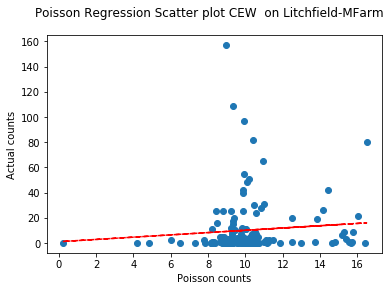

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  147
Model:                            GLM   Df Residuals:                      142
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1238.1
Date:                Tue, 12 May 2020   Deviance:                       2077.8
Time:                        20:20:05   Pearson chi2:                 4.38e+03
No. Iterations:                    11   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3692      0.236     10.045      0.000       1.907       2.831
tempf         -0.3470      0.058     -5.952      0.0

<Figure size 432x288 with 0 Axes>

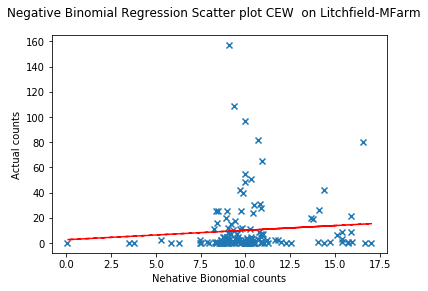

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   57
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -261.86
Date:                Tue, 12 May 2020   Deviance:                       442.06
Time:                        20:20:06   Pearson chi2:                 1.00e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1511      1.593      1.978      0.048       0.028       6.274
tempf         -0.8531      0.300     -2.848      0.0

<Figure size 432x288 with 0 Axes>

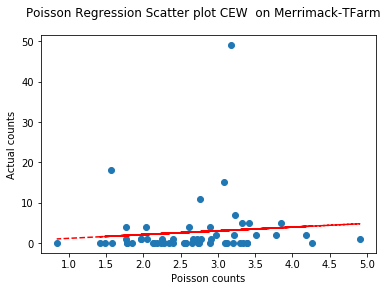

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   57
Model:                            GLM   Df Residuals:                       52
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -109.06
Date:                Tue, 12 May 2020   Deviance:                       31.217
Time:                        20:20:06   Pearson chi2:                     46.0
No. Iterations:                    21   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1483      7.331      1.111      0.266      -6.221      22.517
tempf         -2.0193      1.345     -1.501      0.1

<Figure size 432x288 with 0 Axes>

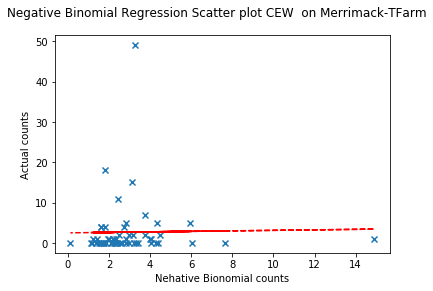

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  131
Model:                            GLM   Df Residuals:                      126
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1651.0
Date:                Tue, 12 May 2020   Deviance:                       2932.4
Time:                        20:20:06   Pearson chi2:                 4.81e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4252      0.176     13.742      0.000       2.079       2.771
tempf         -0.1507      0.033     -4.523      0.0

<Figure size 432x288 with 0 Axes>

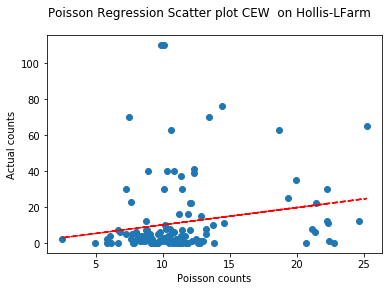

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  131
Model:                            GLM   Df Residuals:                      126
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1097.6
Date:                Tue, 12 May 2020   Deviance:                       1784.8
Time:                        20:20:07   Pearson chi2:                 3.21e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5027      0.222     11.270      0.000       2.067       2.938
tempf         -0.1567      0.038     -4.093      0.0

<Figure size 432x288 with 0 Axes>

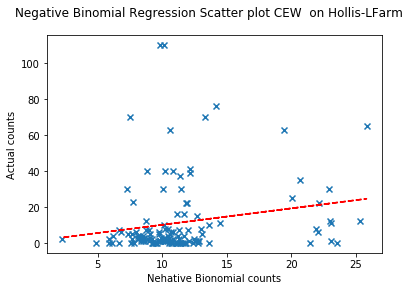

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1648.7
Date:                Tue, 12 May 2020   Deviance:                       3091.3
Time:                        20:20:07   Pearson chi2:                 4.36e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6484      0.496      7.357      0.000       2.676       4.620
tempf         -0.4368      0.089     -4.884      0.0

<Figure size 432x288 with 0 Axes>

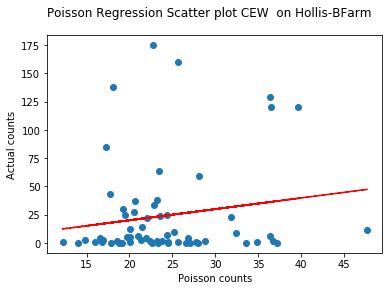

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -355.47
Date:                Tue, 12 May 2020   Deviance:                       420.42
Time:                        20:20:07   Pearson chi2:                     455.
No. Iterations:                    27   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9779      1.537      4.540      0.000       3.966       9.990
tempf         -1.0486      0.273     -3.840      0.0

<Figure size 432x288 with 0 Axes>

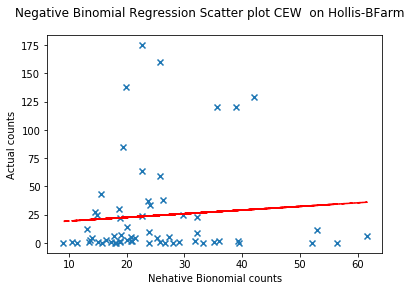

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  150
Model:                            GLM   Df Residuals:                      145
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2617.0
Date:                Tue, 12 May 2020   Deviance:                       4826.3
Time:                        20:20:08   Pearson chi2:                 8.15e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2953      0.161      8.045      0.000       0.980       1.611
tempf         -0.1764      0.033     -5.369      0.0

<Figure size 432x288 with 0 Axes>

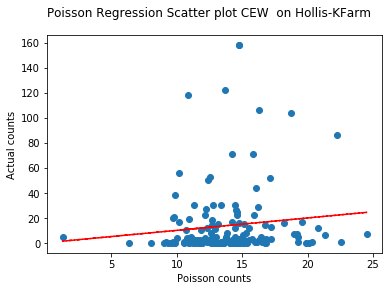

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  150
Model:                            GLM   Df Residuals:                      145
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1829.1
Date:                Tue, 12 May 2020   Deviance:                       3215.4
Time:                        20:20:08   Pearson chi2:                 5.90e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3134      0.189      6.958      0.000       0.943       1.683
tempf         -0.1748      0.037     -4.762      0.0

<Figure size 432x288 with 0 Axes>

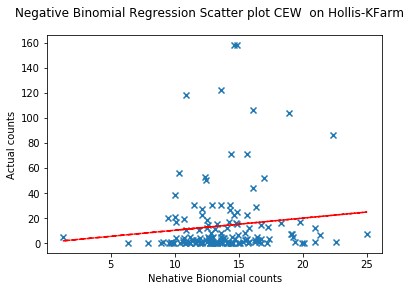

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  133
Model:                            GLM   Df Residuals:                      128
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2587.4
Date:                Tue, 12 May 2020   Deviance:                       4824.0
Time:                        20:20:09   Pearson chi2:                 9.66e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4241      0.168     20.416      0.000       3.095       3.753
tempf         -0.0154      0.027     -0.567      0.5

<Figure size 432x288 with 0 Axes>

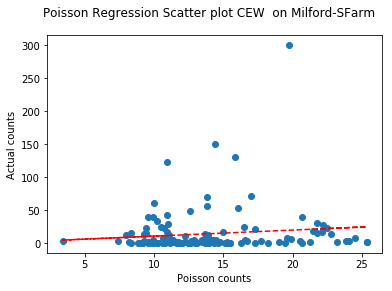

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  133
Model:                            GLM   Df Residuals:                      128
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1302.0
Date:                Tue, 12 May 2020   Deviance:                       2200.3
Time:                        20:20:09   Pearson chi2:                 4.79e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3372      0.243     13.737      0.000       2.861       3.813
tempf         -0.0211      0.035     -0.609      0.5

<Figure size 432x288 with 0 Axes>

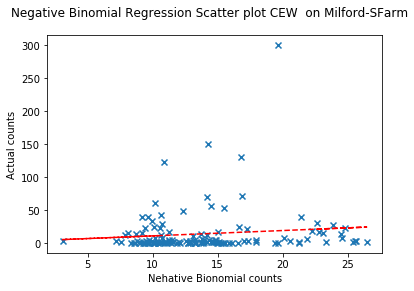

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  142
Model:                            GLM   Df Residuals:                      137
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1251.4
Date:                Tue, 12 May 2020   Deviance:                       2179.9
Time:                        20:20:09   Pearson chi2:                 3.63e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9277      0.261      3.557      0.000       0.416       1.439
tempf         -0.0284      0.039     -0.733      0.4

<Figure size 432x288 with 0 Axes>

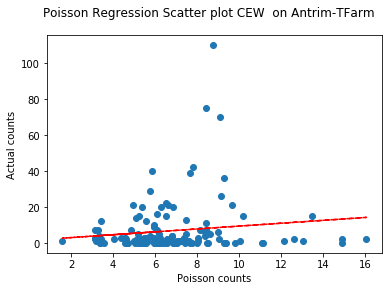

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  142
Model:                            GLM   Df Residuals:                      137
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -649.05
Date:                Tue, 12 May 2020   Deviance:                       903.39
Time:                        20:20:10   Pearson chi2:                 1.46e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6535      0.377      1.735      0.083      -0.085       1.392
tempf         -0.0768      0.061     -1.251      0.2

<Figure size 432x288 with 0 Axes>

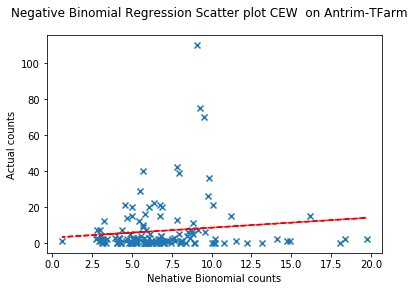

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1691.4
Date:                Tue, 12 May 2020   Deviance:                       3035.8
Time:                        20:20:10   Pearson chi2:                 4.65e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1164      0.175     12.119      0.000       1.774       2.459
tempf         -0.0215      0.049     -0.434      0.6

<Figure size 432x288 with 0 Axes>

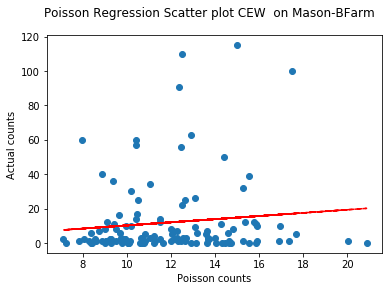

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1191.0
Date:                Tue, 12 May 2020   Deviance:                       2004.6
Time:                        20:20:11   Pearson chi2:                 3.27e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0992      0.210     10.006      0.000       1.688       2.510
tempf         -0.0278      0.058     -0.479      0.6

<Figure size 432x288 with 0 Axes>

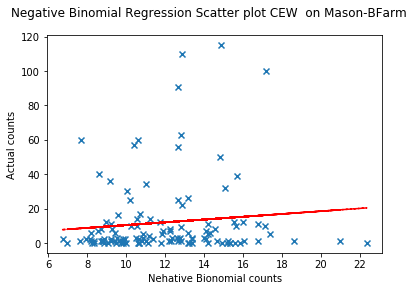

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.90
Date:                Tue, 12 May 2020   Deviance:                       583.82
Time:                        20:20:11   Pearson chi2:                 1.36e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5814      0.688     -5.204      0.000      -4.930      -2.233
tempf         -0.3741      0.173     -2.164      0.0

<Figure size 432x288 with 0 Axes>

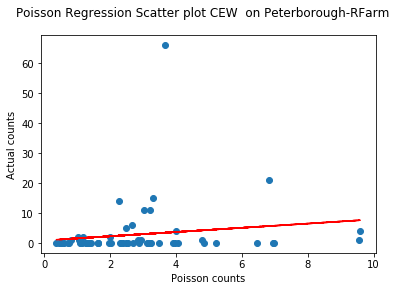

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90.574
Date:                Tue, 12 May 2020   Deviance:                       44.617
Time:                        20:20:11   Pearson chi2:                     58.4
No. Iterations:                    16   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.0354      2.726     -3.681      0.000     -15.378      -4.693
tempf         -1.3147      0.650     -2.023      0.0

<Figure size 432x288 with 0 Axes>

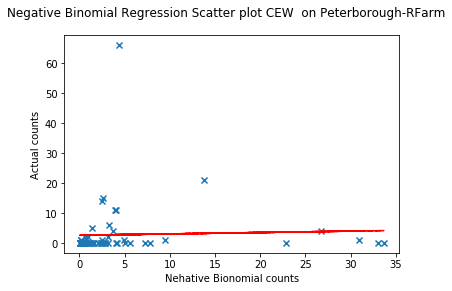

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   99
Model:                            GLM   Df Residuals:                       94
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1313.3
Date:                Tue, 12 May 2020   Deviance:                       2337.7
Time:                        20:20:12   Pearson chi2:                 3.47e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1494      0.196     16.078      0.000       2.766       3.533
tempf         -0.2920      0.056     -5.174      0.0

<Figure size 432x288 with 0 Axes>

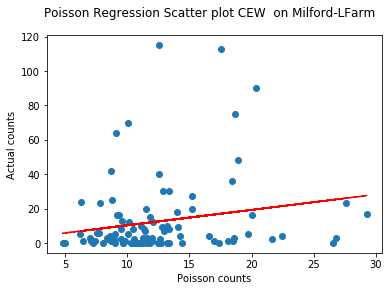

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   99
Model:                            GLM   Df Residuals:                       94
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -786.78
Date:                Tue, 12 May 2020   Deviance:                       1245.4
Time:                        20:20:12   Pearson chi2:                 1.92e+03
No. Iterations:                    12   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8050      0.267     10.520      0.000       2.282       3.328
tempf         -0.5168      0.080     -6.497      0.0

<Figure size 432x288 with 0 Axes>

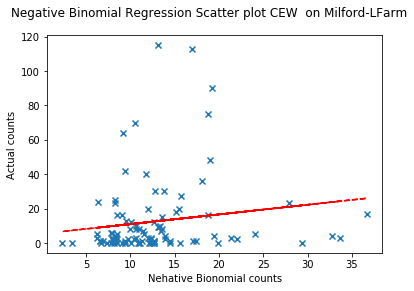

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  129
Model:                            GLM   Df Residuals:                      124
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -481.57
Date:                Tue, 12 May 2020   Deviance:                       747.60
Time:                        20:20:13   Pearson chi2:                 1.02e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1418      0.471     -2.422      0.015      -2.066      -0.218
tempf         -0.1417      0.069     -2.059      0.0

<Figure size 432x288 with 0 Axes>

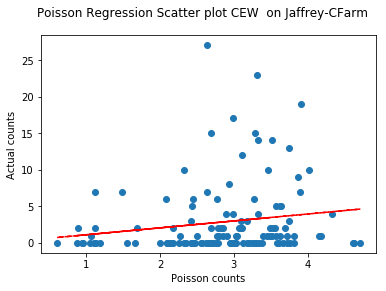

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  129
Model:                            GLM   Df Residuals:                      124
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -271.82
Date:                Tue, 12 May 2020   Deviance:                       70.097
Time:                        20:20:13   Pearson chi2:                     56.5
No. Iterations:                    18   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4257      1.682     -0.848      0.397      -4.722       1.871
tempf         -0.4064      0.378     -1.076      0.2

<Figure size 432x288 with 0 Axes>

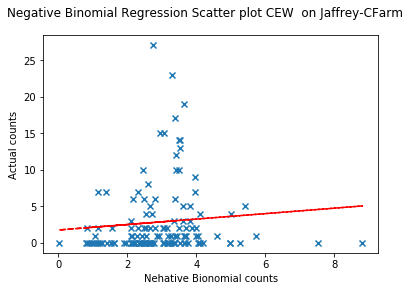

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  119
Model:                            GLM   Df Residuals:                      114
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2285.8
Date:                Tue, 12 May 2020   Deviance:                       4270.5
Time:                        20:20:14   Pearson chi2:                 1.24e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3559      0.438     16.794      0.000       6.497       8.214
tempf         -0.8515      0.079    -10.802      0.0

<Figure size 432x288 with 0 Axes>

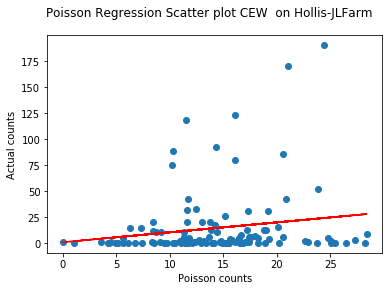

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  119
Model:                            GLM   Df Residuals:                      114
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -808.32
Date:                Tue, 12 May 2020   Deviance:                       1235.1
Time:                        20:20:14   Pearson chi2:                 3.07e+04
No. Iterations:                    19   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8272      0.832      9.405      0.000       6.196       9.458
tempf         -0.9655      0.137     -7.050      0.0

<Figure size 432x288 with 0 Axes>

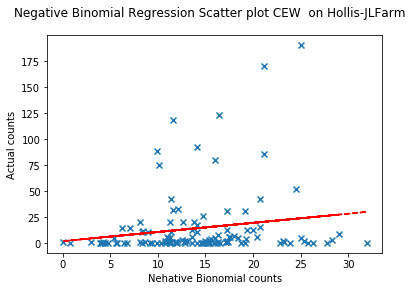

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  125
Model:                            GLM   Df Residuals:                      120
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1912.6
Date:                Tue, 12 May 2020   Deviance:                       3433.8
Time:                        20:20:15   Pearson chi2:                 4.73e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3896      0.162     20.885      0.000       3.071       3.708
tempf         -0.0307      0.025     -1.211      0.2

<Figure size 432x288 with 0 Axes>

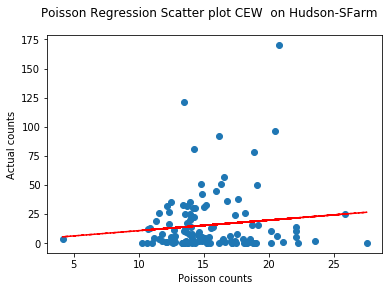

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  125
Model:                            GLM   Df Residuals:                      120
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -986.96
Date:                Tue, 12 May 2020   Deviance:                       1510.0
Time:                        20:20:15   Pearson chi2:                 1.99e+03
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3578      0.246     13.658      0.000       2.876       3.840
tempf         -0.0567      0.037     -1.544      0.1

<Figure size 432x288 with 0 Axes>

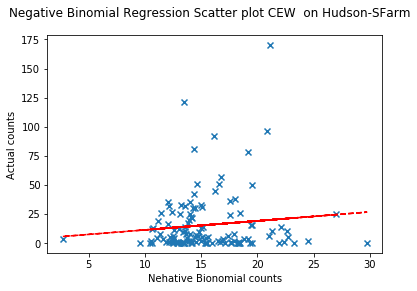

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   72
Model:                            GLM   Df Residuals:                       67
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1757.4
Date:                Tue, 12 May 2020   Deviance:                       3303.5
Time:                        20:20:15   Pearson chi2:                 5.45e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1766      0.206     10.578      0.000       1.773       2.580
tempf         -0.5789      0.047    -12.197      0.0

<Figure size 432x288 with 0 Axes>

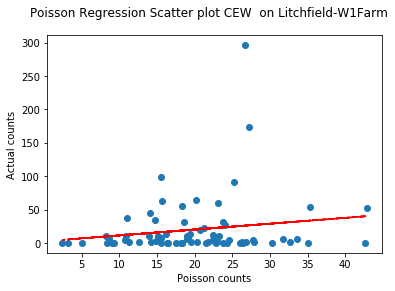

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   72
Model:                            GLM   Df Residuals:                       67
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -407.16
Date:                Tue, 12 May 2020   Deviance:                       521.56
Time:                        20:20:16   Pearson chi2:                     662.
No. Iterations:                    15   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7770      0.524      3.392      0.001       0.750       2.804
tempf         -1.0255      0.127     -8.072      0.0

<Figure size 432x288 with 0 Axes>

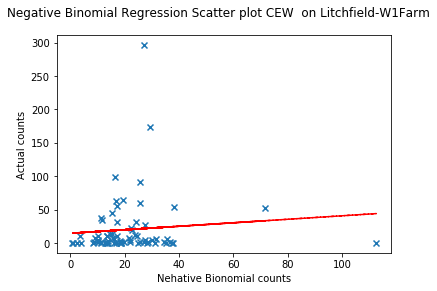

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   51
Model:                            GLM   Df Residuals:                       46
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1286.7
Date:                Tue, 12 May 2020   Deviance:                       2415.4
Time:                        20:20:16   Pearson chi2:                 3.35e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0396      0.658     -1.580      0.114      -2.329       0.250
tempf         -0.2555      0.076     -3.381      0.0

<Figure size 432x288 with 0 Axes>

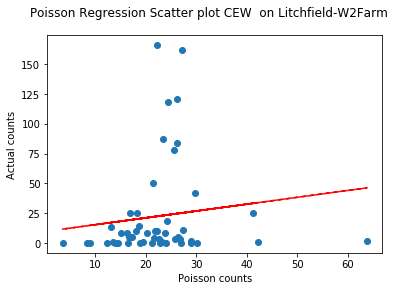

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   51
Model:                            GLM   Df Residuals:                       46
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -266.83
Date:                Tue, 12 May 2020   Deviance:                       310.28
Time:                        20:20:16   Pearson chi2:                     288.
No. Iterations:                    31   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8476      1.967     -1.956      0.051      -7.704       0.008
tempf         -1.6103      0.275     -5.855      0.0

<Figure size 432x288 with 0 Axes>

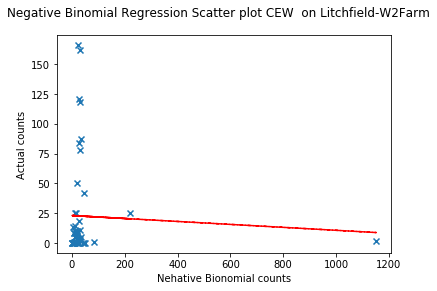

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   72
Model:                            GLM   Df Residuals:                       67
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -905.42
Date:                Tue, 12 May 2020   Deviance:                       1582.2
Time:                        20:20:17   Pearson chi2:                 2.19e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0249      0.230     13.169      0.000       2.575       3.475
tempf         -0.0934      0.034     -2.736      0.0

<Figure size 432x288 with 0 Axes>

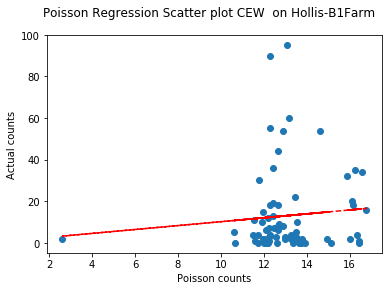

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   72
Model:                            GLM   Df Residuals:                       67
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -717.76
Date:                Tue, 12 May 2020   Deviance:                       1192.3
Time:                        20:20:17   Pearson chi2:                 1.72e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0058      0.260     11.564      0.000       2.496       3.515
tempf         -0.0995      0.037     -2.664      0.0

<Figure size 432x288 with 0 Axes>

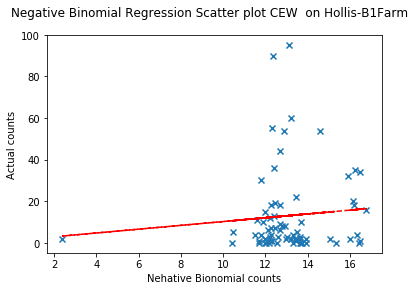

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   56
Model:                            GLM   Df Residuals:                       51
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -477.03
Date:                Tue, 12 May 2020   Deviance:                       814.54
Time:                        20:20:17   Pearson chi2:                 1.12e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5923      0.377      6.882      0.000       1.854       3.331
tempf         -0.0160      0.031     -0.511      0.6

<Figure size 432x288 with 0 Axes>

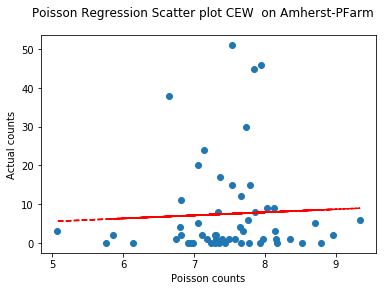

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   56
Model:                            GLM   Df Residuals:                       51
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -346.73
Date:                Tue, 12 May 2020   Deviance:                       537.82
Time:                        20:20:18   Pearson chi2:                     770.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6789      0.455      5.891      0.000       1.788       3.570
tempf         -0.0176      0.037     -0.474      0.6

<Figure size 432x288 with 0 Axes>

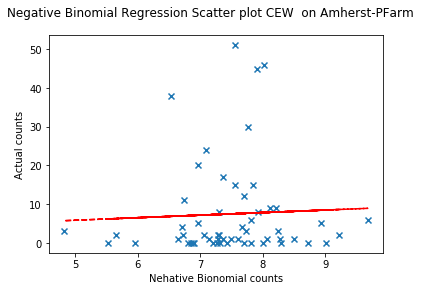

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   78
Model:                            GLM   Df Residuals:                       73
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -529.64
Date:                Tue, 12 May 2020   Deviance:                       885.38
Time:                        20:20:18   Pearson chi2:                 1.17e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2519      0.313     10.395      0.000       2.639       3.865
tempf         -0.2553      0.081     -3.156      0.0

<Figure size 432x288 with 0 Axes>

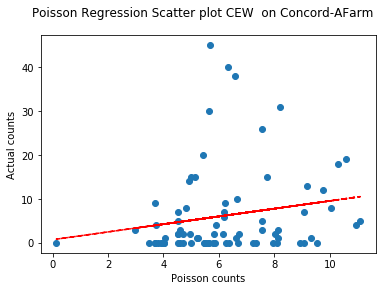

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   78
Model:                            GLM   Df Residuals:                       73
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -268.45
Date:                Tue, 12 May 2020   Deviance:                       300.81
Time:                        20:20:18   Pearson chi2:                     356.
No. Iterations:                    18   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5330      0.580      6.088      0.000       2.396       4.670
tempf         -0.4096      0.153     -2.672      0.0

<Figure size 432x288 with 0 Axes>

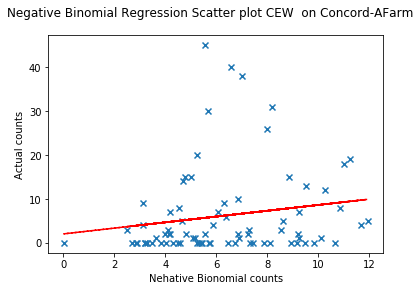

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   72
Model:                            GLM   Df Residuals:                       67
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -241.88
Date:                Tue, 12 May 2020   Deviance:                       385.61
Time:                        20:20:19   Pearson chi2:                     605.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7517      0.518      1.452      0.147      -0.263       1.767
tempf         -0.4517      0.181     -2.491      0.0

<Figure size 432x288 with 0 Axes>

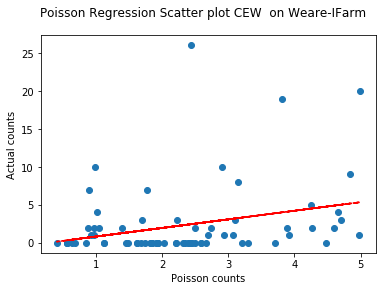

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   72
Model:                            GLM   Df Residuals:                       67
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.63
Date:                Tue, 12 May 2020   Deviance:                       29.634
Time:                        20:20:19   Pearson chi2:                     29.9
No. Iterations:                    33   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3769      2.501      0.950      0.342      -2.526       7.280
tempf         -0.4935      0.692     -0.713      0.4

<Figure size 432x288 with 0 Axes>

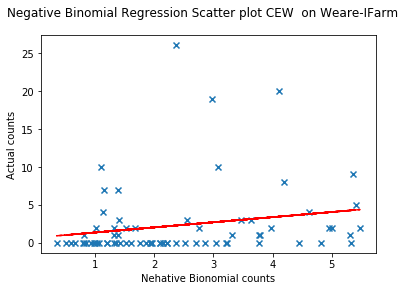

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   51
Model:                            GLM   Df Residuals:                       46
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -217.57
Date:                Tue, 12 May 2020   Deviance:                       346.02
Time:                        20:20:20   Pearson chi2:                     485.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8866      0.577      1.537      0.124      -0.244       2.018
tempf         -0.7883      0.238     -3.318      0.0

<Figure size 432x288 with 0 Axes>

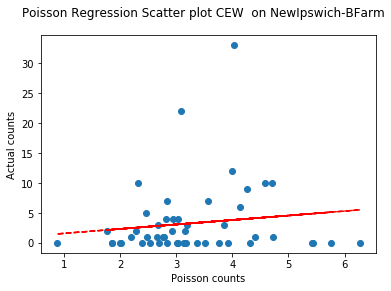

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   51
Model:                            GLM   Df Residuals:                       46
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -108.68
Date:                Tue, 12 May 2020   Deviance:                       37.536
Time:                        20:20:20   Pearson chi2:                     31.0
No. Iterations:                    19   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7609      2.109      0.361      0.718      -3.374       4.895
tempf         -1.7103      0.882     -1.939      0.0

<Figure size 432x288 with 0 Axes>

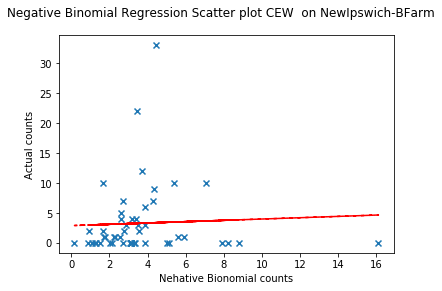

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   60
Model:                            GLM   Df Residuals:                       55
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -370.38
Date:                Tue, 12 May 2020   Deviance:                       614.30
Time:                        20:20:20   Pearson chi2:                     767.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8379      0.387      4.753      0.000       1.080       2.596
tempf         -0.2994      0.118     -2.540      0.0

<Figure size 432x288 with 0 Axes>

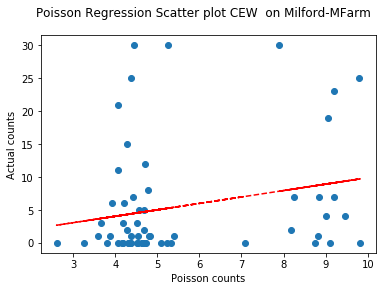

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   60
Model:                            GLM   Df Residuals:                       55
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -181.13
Date:                Tue, 12 May 2020   Deviance:                       179.83
Time:                        20:20:20   Pearson chi2:                     190.
No. Iterations:                    22   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5722      0.785      2.002      0.045       0.033       3.112
tempf         -0.6749      0.235     -2.870      0.0

<Figure size 432x288 with 0 Axes>

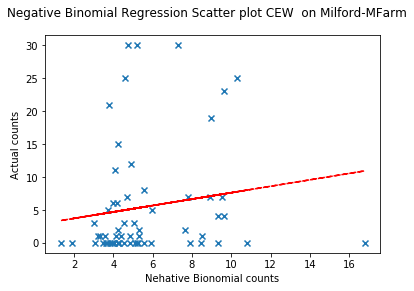

In [61]:
farm_count = 0
all_CEW_FARMS_DataFrame = []
compute_CEW_FARMS = []

for farm in all_CEW_FARMS:
    farmsdataframe = "df_CEW_" + farm 
    farmsdataframe = df_CEW_final.loc[df_CEW_final['farm'] == farm]
    
    count_row = farmsdataframe.shape[0]
    
    #print ((farmsdataframe['trap_count'] > 1).any())
    if (farmsdataframe['trap_count'] > 1).any() == True:
        
        #computing if there more than 50 records 
        if count_row > 50:
            
            #poission regression
            farmsdataframe = Poisson_Regression(farmsdataframe," CEW ", farm)
            
            #negative binomial regression
            farmsdataframe = Negative_Binomial_Regression(farmsdataframe," CEW ", farm)
        
            all_CEW_FARMS_DataFrame.append(farmsdataframe)
            
            compute_CEW_FARMS.append(farm)
        
            farm_count = farm_count + 1

In [62]:
print ("total farms ", farm_count)

total farms  23


In [63]:
#valid farms that are used for predictions
compute_CEW_FARMS

['Pelham-G',
 'Litchfield-W',
 'Litchfield-M',
 'Merrimack-T',
 'Hollis-L',
 'Hollis-B',
 'Hollis-K',
 'Milford-S',
 'Antrim-T',
 'Mason-B',
 'Peterborough-R',
 'Milford-L',
 'Jaffrey-C',
 'Hollis-JL',
 'Hudson-S',
 'Litchfield-W1',
 'Litchfield-W2',
 'Hollis-B1',
 'Amherst-P',
 'Concord-A',
 'Weare-I',
 'NewIpswich-B',
 'Milford-M']

In [64]:
all_CEW_FARMS_DataFrame[1].head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,26,15
12,Litchfield-W,0,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,11,10,10,18,11
23,Litchfield-W,3,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,11,12,12,31,30
34,Litchfield-W,1,2006,2006-07-10,71.830909,66.491782,59.745455,72.608255,10,10,10,19,10
46,Litchfield-W,1,2006,2006-07-17,73.200175,66.515808,101.004367,74.150786,11,11,11,15,10


In [65]:
df_CEW_final['poisson_count_farm'] = 0
df_CEW_final['NB_count_farm'] = 0

In [66]:
#combining all the computed counts on the major dataframe 
count = 0 
for df_Farm in all_CEW_FARMS_DataFrame:
    #print (df_Farm.head()) 
    
    #getting all poission regression count 
    df_CEW_final.loc[df_CEW_final.farm == compute_CEW_FARMS[count], ['poisson_count_farm']] = df_Farm.loc[df_Farm.farm == compute_CEW_FARMS[count], ['poisson_count_farm']]
    
    #getting all negative binomial regression count 
    df_CEW_final.loc[df_CEW_final.farm == compute_CEW_FARMS[count], ['NB_count_farm']] = df_Farm.loc[df_Farm.farm == compute_CEW_FARMS[count], ['NB_count_farm']]
    
    count = count + 1

In [67]:
print("total farms ", count )

total farms  23


In [68]:
df_CEW_final

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,3,3
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,26,15
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,9,9
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,1,1
4,Hollis-L,1,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,8,8
5,Hollis-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,13,11
6,Hollis-K,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,10,10
7,Milford-S,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,11,10
8,Antrim-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,6,5
9,Mason-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,10,10,10,8,8


In [69]:
#writing into the csv file
df_CEW_final.to_csv("CEW_predicted_count.csv", index = False, sep = ',')

# Selecting weather dataframe within the date range - ECB Pest

In [70]:
print(search_ecb_STdate)
print(search_ecb_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


In [71]:
df_equation_ECB = df_equation.loc[(df_equation['valid'] >= search_ecb_STdate) & (df_equation['valid'] <= search_ecb_ENDdate), :]

In [72]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf_ECB = df_equation_ECB[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf_ECB["tmpf"] = df_tempf_ECB["tmpf"].fillna(0)
df_tempf_ECB["dwpf"] = df_tempf_ECB["dwpf"].fillna(0)
df_tempf_ECB["drct"] = df_tempf_ECB["drct"].fillna(0)
df_tempf_ECB["feel"] = df_tempf_ECB["feel"].fillna(0)

In [73]:
#calling getweekly_temperature
ECB_weather_data_dic = {}
getweekly_temperature(df_tempf_ECB,ECB_weather_data_dic)

total temperature index  642
total weeks:  47922


In [74]:
df_ECB_weather = pd.DataFrame(ECB_weather_data_dic)

In [75]:
df_ECB['date'] = df_ECB['date'].dt.date

In [76]:
#combining weather data and pest count data based on the date -----
#creating data frame needed for equation
df_ECB_weather['date'] = pd.to_datetime(df_ECB_weather['date'])
df_ECB_weather['date'] = df_ECB_weather['date'].dt.date
df_ECB_final = df_ECB.merge(df_ECB_weather, on='date')

In [77]:
df_ECB_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel
0,Litchfield-W,16,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
1,Hollis-B,7,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
2,Mason-B,11,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
3,Litchfield-W,25,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347
4,Hollis-B,31,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347


# Pest Trap Predictions - ECB pest

In [78]:
df_ECB_final.columns

Index(['farm', 'trap_count', 'year', 'date', 'tempf', 'dwpf', 'drct', 'feel'], dtype='object')

In [79]:
df_ECB_final.describe()

,trap_count,year,tempf,dwpf,drct,feel
count,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000
mean,2.983333,2012.195025,59.654599,51.780452,111.007756,59.059063
std,7.848083,3.125599,19.106491,16.729400,28.609778,19.336951
min,0.000000,2006.000000,5.991987,4.820875,42.116788,5.967797
25%,0.000000,2010.000000,58.973756,51.240271,92.802768,57.877413
50%,0.000000,2012.000000,66.157346,57.382674,108.388626,66.109162
75%,3.000000,2014.000000,70.040112,61.507429,128.214654,70.062183
max,113.000000,2018.000000,79.977751,68.505141,225.337423,81.125680


# 1. Multiple Linear Regression on all data 

Intercept:  3.3808220267663303
Coeffecients  [ 0.04189007  0.04614086 -0.00587125 -0.07856854]
(804,)
----------- Linear Regression Evaluations------------
Mean Absolute Error (MAE):  4.021307385460009
Mean Squared Eror (MSE):  61.86105644875795
Root Mean Squared Eror (RMSE):  7.865180001039897


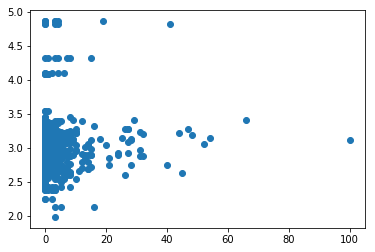

In [80]:
df_ECB_final = Multiple_Linear_Regression(df_ECB_final)

# 2. Poission Regression on all data 

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 4020
Model:                            GLM   Df Residuals:                     4015
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20982.
Date:                Tue, 12 May 2020   Deviance:                       36540.
Time:                        20:21:02   Pearson chi2:                 8.28e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2365      0.070     17.763      0.000       1.100       1.373
tempf         -0.0035      0.004     -0.925      0.3

<Figure size 432x288 with 0 Axes>

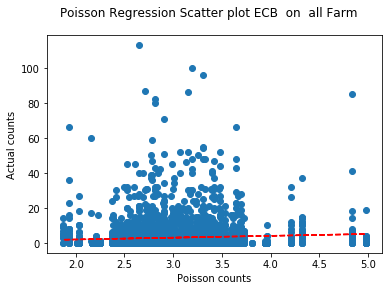

In [81]:
df_ECB_final = Poisson_Regression(df_ECB_final," ECB ", " all ")

# 3. Negative Binomial Regression on all data 

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 4020
Model:                            GLM   Df Residuals:                     4015
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13039.
Date:                Tue, 12 May 2020   Deviance:                       19361.
Time:                        20:21:03   Pearson chi2:                 4.92e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1577      0.090     12.929      0.000       0.982       1.333
tempf         -0.0057      0.005     -1.141      0.2

<Figure size 432x288 with 0 Axes>

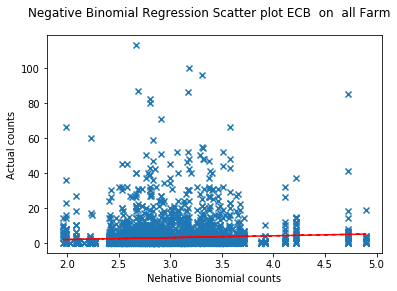

In [82]:
df_ECB_final = Negative_Binomial_Regression(df_ECB_final, " ECB ", " all ")

In [83]:
df_ECB_final

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count
0,Litchfield-W,16,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,3,3,3
1,Hollis-B,7,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,3,3,3
2,Mason-B,11,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,3,3,3
3,Litchfield-W,25,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,3,3,3
4,Hollis-B,31,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,3,3,3
5,Mason-B,7,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,3,3,3
6,Litchfield-W,3,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,2,2,2
7,Hollis-B,4,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,2,2,2
8,Mason-B,1,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,2,2,2
9,Litchfield-W,12,2006,2006-07-10,71.830909,66.491782,59.745455,72.608255,3,3,3


In [84]:
#all the farms for this pest 
all_ECB_FARMS = df_ECB_final.farm.unique()

In [85]:
all_ECB_FARMS

array(['Litchfield-W', 'Hollis-B', 'Mason-B', 'Milford-S', 'Hollis-K',
       'Nashua-S', 'Antrim-T', 'Jaffrey-C', 'Merrimack-T', 'Pelham-G',
       'Hollis-L', 'Litchfield-M', 'Hudson-S', 'Hollis-JL', 'Milford-L',
       'Peterborough-R', 'Merrimack-S', 'Concord-A', 'Amherst-P',
       'Concord-D2', 'Concord-P', 'Loudon-P', 'Boscawen-C', 'Weare-I',
       'Concord-D1', 'NewBoston-M', 'Milford-M', 'Loudon-P1', 'Loudon-P2',
       'Dunbarton', 'NewIpswich-B', 'Bradford-W', 'NewLondon-SL',
       'Concord-D', 'Surry-G', 'Plainfield-E', 'Plymouth-L', 'Bristol-W',
       'Grafton-AH', 'SugarHill-SH', 'NorthHaverhill-GC', 'Piermont-PM',
       'Derry-JF', 'Durham-T', 'Stratham-B', 'Hollis-JL-Pl',
       'Hollis-JL-T', 'Goffstown-D', 'NewBoston-D', 'CenterConway-S',
       'Claremont-TL', 'Meredith-M', 'Pelham-C'], dtype=object)

In [86]:
all_ECB_FARMS.shape

(53,)

# Poission & Negative Binomial Regression for each Farms

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  215
Model:                            GLM   Df Residuals:                      210
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1856.7
Date:                Tue, 12 May 2020   Deviance:                       3245.3
Time:                        20:21:03   Pearson chi2:                 5.14e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4325      0.219      6.535      0.000       1.003       1.862
tempf          0.0247      0.015      1.681      0.0

<Figure size 432x288 with 0 Axes>

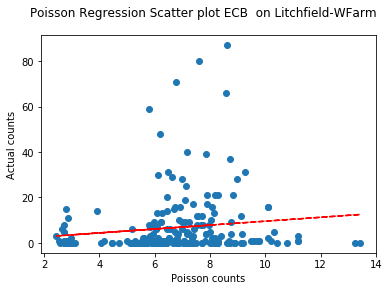

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  215
Model:                            GLM   Df Residuals:                      210
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -781.56
Date:                Tue, 12 May 2020   Deviance:                       919.16
Time:                        20:21:04   Pearson chi2:                 1.32e+03
No. Iterations:                    11   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7179      0.400      4.295      0.000       0.934       2.502
tempf          0.0477      0.025      1.887      0.0

<Figure size 432x288 with 0 Axes>

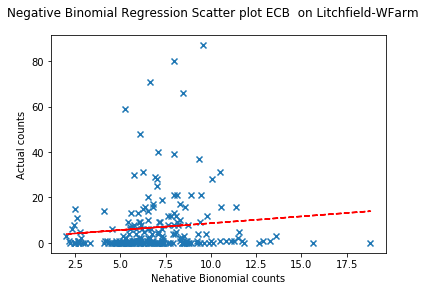

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  204
Model:                            GLM   Df Residuals:                      199
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1431.2
Date:                Tue, 12 May 2020   Deviance:                       2487.8
Time:                        20:21:04   Pearson chi2:                 4.12e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0776      0.241      0.322      0.747      -0.394       0.549
tempf         -0.1177      0.018     -6.622      0.0

<Figure size 432x288 with 0 Axes>

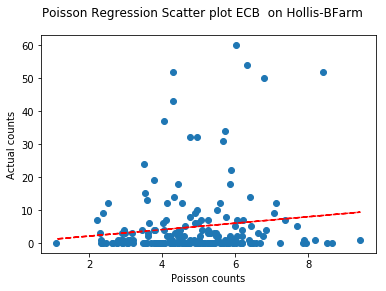

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  204
Model:                            GLM   Df Residuals:                      199
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -815.01
Date:                Tue, 12 May 2020   Deviance:                       1166.8
Time:                        20:21:05   Pearson chi2:                 2.01e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0323      0.341      0.095      0.925      -0.637       0.701
tempf         -0.1164      0.023     -5.132      0.0

<Figure size 432x288 with 0 Axes>

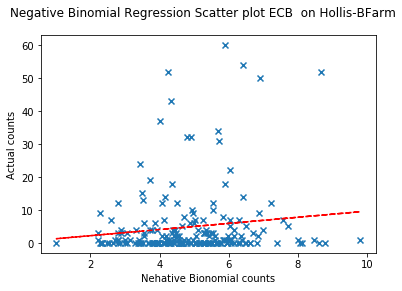

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  217
Model:                            GLM   Df Residuals:                      212
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -641.11
Date:                Tue, 12 May 2020   Deviance:                       991.54
Time:                        20:21:05   Pearson chi2:                 1.41e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3930      0.431     -0.912      0.362      -1.237       0.451
tempf          0.0047      0.021      0.221      0.8

<Figure size 432x288 with 0 Axes>

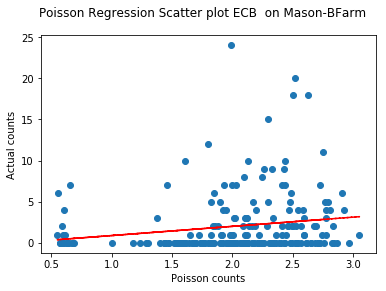

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  217
Model:                            GLM   Df Residuals:                      212
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -457.14
Date:                Tue, 12 May 2020   Deviance:                       526.56
Time:                        20:21:06   Pearson chi2:                     736.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3101      0.545     -0.569      0.569      -1.377       0.757
tempf         -0.0009      0.030     -0.029      0.9

<Figure size 432x288 with 0 Axes>

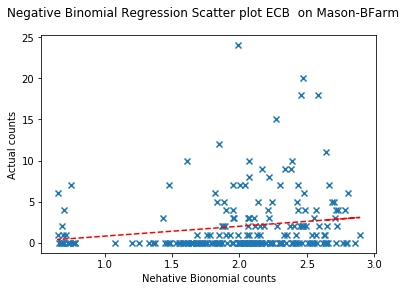

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  199
Model:                            GLM   Df Residuals:                      194
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1476.6
Date:                Tue, 12 May 2020   Deviance:                       2480.1
Time:                        20:21:06   Pearson chi2:                 3.03e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8103      0.201      8.999      0.000       1.416       2.205
tempf          0.0433      0.010      4.201      0.0

<Figure size 432x288 with 0 Axes>

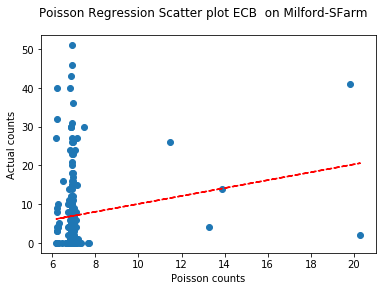

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  199
Model:                            GLM   Df Residuals:                      194
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -721.51
Date:                Tue, 12 May 2020   Deviance:                       787.11
Time:                        20:21:06   Pearson chi2:                     801.
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7637      0.388      4.543      0.000       1.003       2.525
tempf          0.0394      0.023      1.727      0.0

<Figure size 432x288 with 0 Axes>

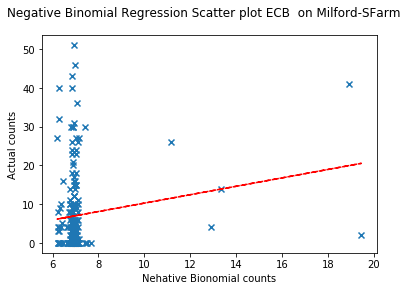

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  191
Model:                            GLM   Df Residuals:                      186
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1077.5
Date:                Tue, 12 May 2020   Deviance:                       1772.5
Time:                        20:21:07   Pearson chi2:                 2.45e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2233      0.286      4.283      0.000       0.664       1.783
tempf         -0.1229      0.024     -5.068      0.0

<Figure size 432x288 with 0 Axes>

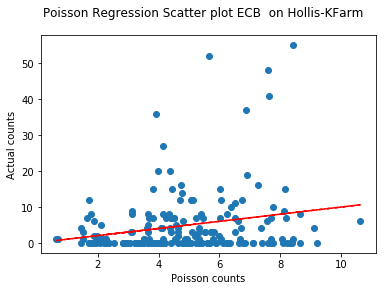

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  191
Model:                            GLM   Df Residuals:                      186
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -663.84
Date:                Tue, 12 May 2020   Deviance:                       850.04
Time:                        20:21:07   Pearson chi2:                 1.13e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1125      0.386      2.879      0.004       0.355       1.870
tempf         -0.1182      0.028     -4.180      0.0

<Figure size 432x288 with 0 Axes>

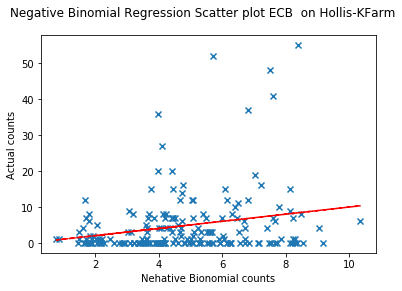

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  163
Model:                            GLM   Df Residuals:                      158
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -322.17
Date:                Tue, 12 May 2020   Deviance:                       520.07
Time:                        20:21:07   Pearson chi2:                     811.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1163      1.071     -1.976      0.048      -4.215      -0.017
tempf          0.0267      0.032      0.822      0.4

<Figure size 432x288 with 0 Axes>

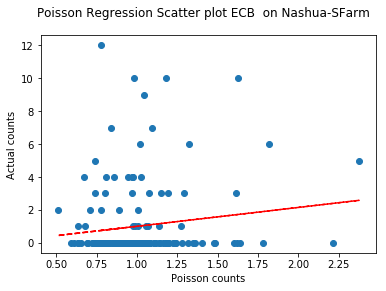

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  163
Model:                            GLM   Df Residuals:                      158
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -275.53
Date:                Tue, 12 May 2020   Deviance:                       401.36
Time:                        20:21:08   Pearson chi2:                     657.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9777      1.192     -1.659      0.097      -4.314       0.359
tempf          0.0248      0.037      0.670      0.5

<Figure size 432x288 with 0 Axes>

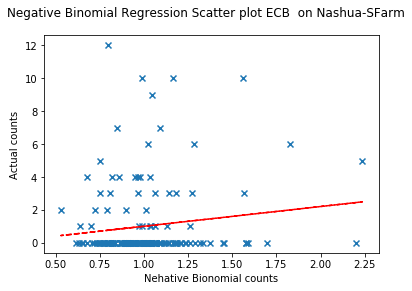

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  187
Model:                            GLM   Df Residuals:                      182
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -425.36
Date:                Tue, 12 May 2020   Deviance:                       669.50
Time:                        20:21:08   Pearson chi2:                 1.31e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4901      0.607     -4.103      0.000      -3.680      -1.301
tempf         -0.0696      0.047     -1.473      0.1

<Figure size 432x288 with 0 Axes>

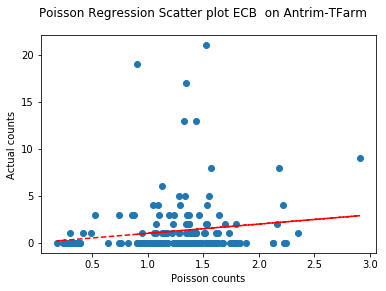

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  187
Model:                            GLM   Df Residuals:                      182
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -354.57
Date:                Tue, 12 May 2020   Deviance:                       499.83
Time:                        20:21:08   Pearson chi2:                 1.07e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4860      0.667     -3.725      0.000      -3.794      -1.178
tempf         -0.0704      0.050     -1.405      0.1

<Figure size 432x288 with 0 Axes>

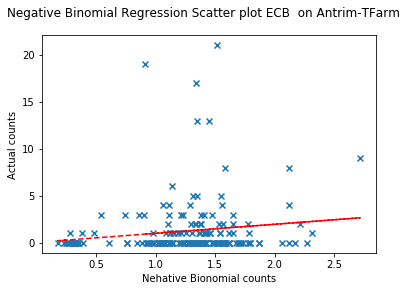

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  188
Model:                            GLM   Df Residuals:                      183
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.43
Date:                Tue, 12 May 2020   Deviance:                       1140.6
Time:                        20:21:09   Pearson chi2:                 1.95e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0679      0.377     -2.832      0.005      -1.807      -0.329
tempf         -0.1008      0.025     -3.966      0.0

<Figure size 432x288 with 0 Axes>

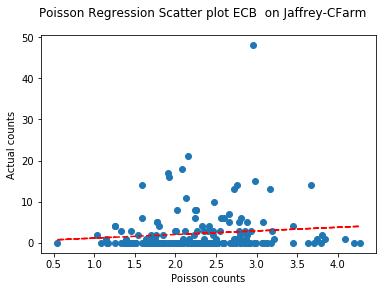

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  188
Model:                            GLM   Df Residuals:                      183
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -465.87
Date:                Tue, 12 May 2020   Deviance:                       625.17
Time:                        20:21:09   Pearson chi2:                 1.10e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2719      0.493     -2.581      0.010      -2.238      -0.306
tempf         -0.1099      0.032     -3.480      0.0

<Figure size 432x288 with 0 Axes>

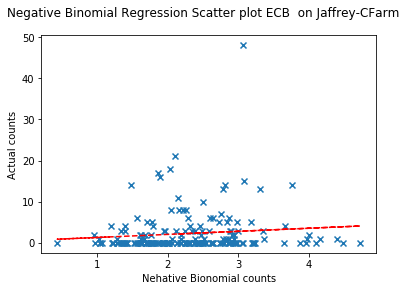

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   53
Model:                            GLM   Df Residuals:                       48
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26.613
Date:                Tue, 12 May 2020   Deviance:                       33.242
Time:                        20:21:09   Pearson chi2:                     49.4
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5494      7.281      0.213      0.831     -12.721      15.820
tempf         -2.9333      1.193     -2.458      0.0

<Figure size 432x288 with 0 Axes>

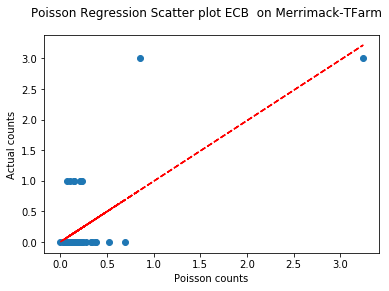

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   53
Model:                            GLM   Df Residuals:                       48
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.939
Date:                Tue, 12 May 2020   Deviance:                       10.672
Time:                        20:21:10   Pearson chi2:                     15.2
No. Iterations:                    11   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0345     13.782      0.003      0.998     -26.978      27.047
tempf         -3.1796      3.354     -0.948      0.3

<Figure size 432x288 with 0 Axes>

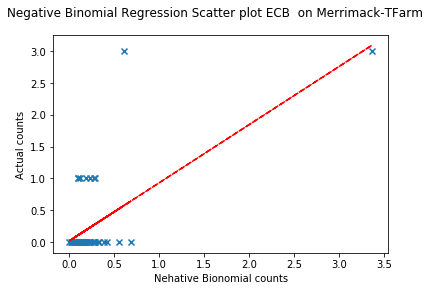

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      152
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -596.34
Date:                Tue, 12 May 2020   Deviance:                       942.62
Time:                        20:21:10   Pearson chi2:                 1.37e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1606      0.618      3.497      0.000       0.950       3.372
tempf         -0.0289      0.023     -1.231      0.2

<Figure size 432x288 with 0 Axes>

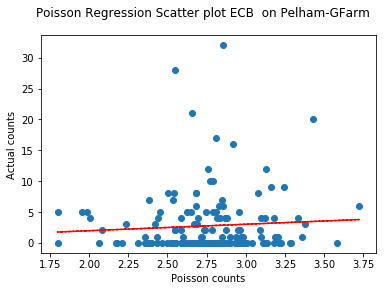

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      152
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -420.98
Date:                Tue, 12 May 2020   Deviance:                       526.49
Time:                        20:21:11   Pearson chi2:                     759.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2113      0.832      2.659      0.008       0.581       3.841
tempf         -0.0299      0.030     -0.981      0.3

<Figure size 432x288 with 0 Axes>

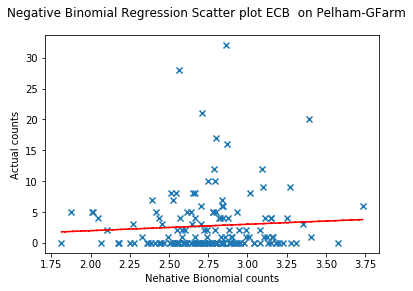

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  181
Model:                            GLM   Df Residuals:                      176
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -717.81
Date:                Tue, 12 May 2020   Deviance:                       1190.5
Time:                        20:21:11   Pearson chi2:                 2.00e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3714      0.368      1.010      0.312      -0.349       1.092
tempf         -0.1221      0.021     -5.860      0.0

<Figure size 432x288 with 0 Axes>

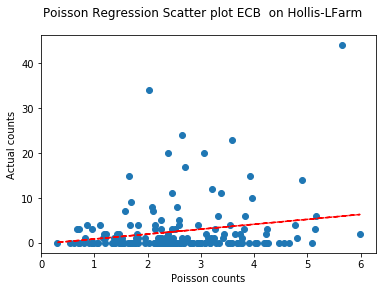

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  181
Model:                            GLM   Df Residuals:                      176
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -491.96
Date:                Tue, 12 May 2020   Deviance:                       683.50
Time:                        20:21:12   Pearson chi2:                 1.22e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5408      0.462      1.169      0.242      -0.366       1.447
tempf         -0.1115      0.027     -4.159      0.0

<Figure size 432x288 with 0 Axes>

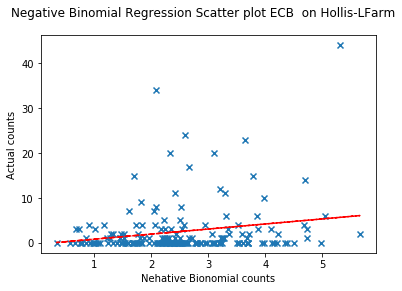

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  171
Model:                            GLM   Df Residuals:                      166
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1511.6
Date:                Tue, 12 May 2020   Deviance:                       2706.9
Time:                        20:21:12   Pearson chi2:                 6.81e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4918      0.246      6.064      0.000       1.010       1.974
tempf         -0.1026      0.014     -7.232      0.0

<Figure size 432x288 with 0 Axes>

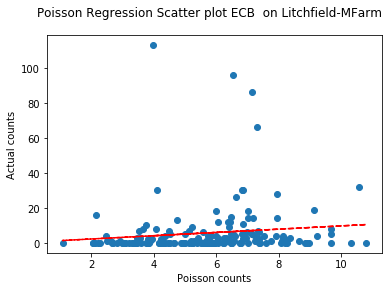

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  171
Model:                            GLM   Df Residuals:                      166
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -661.59
Date:                Tue, 12 May 2020   Deviance:                       909.53
Time:                        20:21:12   Pearson chi2:                 2.66e+03
No. Iterations:                    10   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9482      0.408      2.322      0.020       0.148       1.748
tempf         -0.1237      0.024     -5.218      0.0

<Figure size 432x288 with 0 Axes>

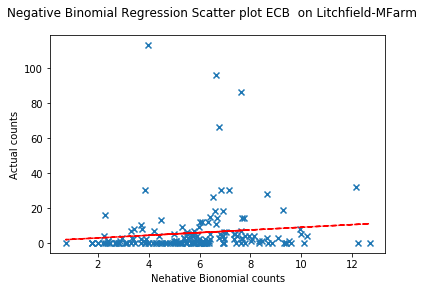

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  178
Model:                            GLM   Df Residuals:                      173
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1552.9
Date:                Tue, 12 May 2020   Deviance:                       2720.3
Time:                        20:21:12   Pearson chi2:                 4.51e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1288      0.198     15.788      0.000       2.740       3.517
tempf         -0.0197      0.014     -1.443      0.1

<Figure size 432x288 with 0 Axes>

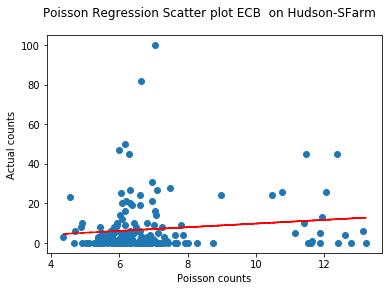

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  178
Model:                            GLM   Df Residuals:                      173
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -654.47
Date:                Tue, 12 May 2020   Deviance:                       773.59
Time:                        20:21:13   Pearson chi2:                 1.18e+03
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3825      0.405      8.348      0.000       2.588       4.177
tempf         -0.0156      0.025     -0.619      0.5

<Figure size 432x288 with 0 Axes>

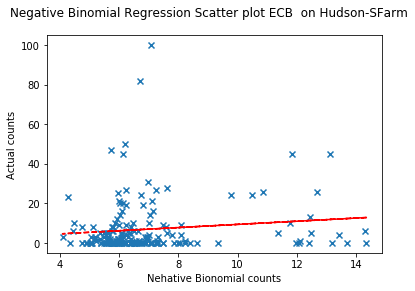

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  148
Model:                            GLM   Df Residuals:                      143
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -422.12
Date:                Tue, 12 May 2020   Deviance:                       675.50
Time:                        20:21:13   Pearson chi2:                 1.40e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8366      0.786      4.884      0.000       2.297       5.376
tempf         -0.0812      0.028     -2.949      0.0

<Figure size 432x288 with 0 Axes>

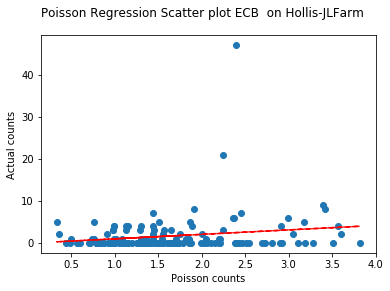

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  148
Model:                            GLM   Df Residuals:                      143
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -284.59
Date:                Tue, 12 May 2020   Deviance:                       347.58
Time:                        20:21:14   Pearson chi2:                     755.
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8137      1.088      3.504      0.000       1.681       5.947
tempf         -0.0836      0.038     -2.215      0.0

<Figure size 432x288 with 0 Axes>

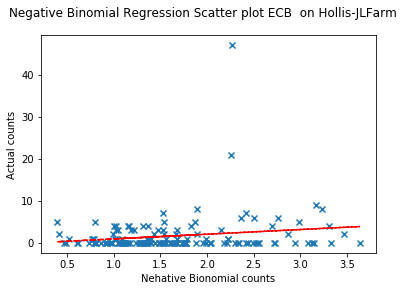

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  171
Model:                            GLM   Df Residuals:                      166
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -493.79
Date:                Tue, 12 May 2020   Deviance:                       750.82
Time:                        20:21:14   Pearson chi2:                     881.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9360      0.374      7.852      0.000       2.203       3.669
tempf         -0.0218      0.026     -0.827      0.4

<Figure size 432x288 with 0 Axes>

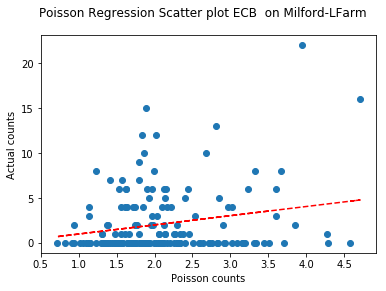

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  171
Model:                            GLM   Df Residuals:                      166
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -378.83
Date:                Tue, 12 May 2020   Deviance:                       456.21
Time:                        20:21:15   Pearson chi2:                     508.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8552      0.507      5.629      0.000       1.861       3.849
tempf         -0.0352      0.033     -1.059      0.2

<Figure size 432x288 with 0 Axes>

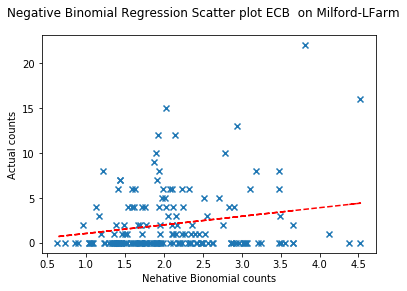

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  165
Model:                            GLM   Df Residuals:                      160
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -179.07
Date:                Tue, 12 May 2020   Deviance:                       265.56
Time:                        20:21:15   Pearson chi2:                     473.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1445      0.975     -0.148      0.882      -2.055       1.766
tempf          0.1689      0.036      4.662      0.0

<Figure size 432x288 with 0 Axes>

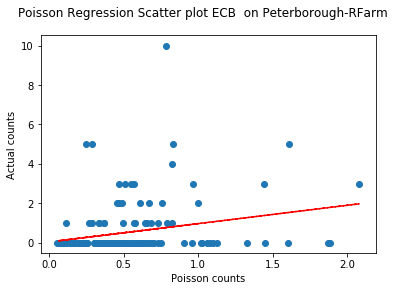

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  165
Model:                            GLM   Df Residuals:                      160
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -138.97
Date:                Tue, 12 May 2020   Deviance:                       89.305
Time:                        20:21:15   Pearson chi2:                     160.
No. Iterations:                    11   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7921      1.698     -0.467      0.641      -4.120       2.535
tempf          0.2056      0.080      2.563      0.0

<Figure size 432x288 with 0 Axes>

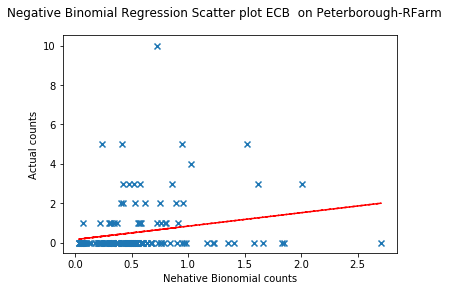

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  132
Model:                            GLM   Df Residuals:                      127
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -228.03
Date:                Tue, 12 May 2020   Deviance:                       360.70
Time:                        20:21:16   Pearson chi2:                     629.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0302      0.697      0.043      0.965      -1.336       1.396
tempf         -0.0368      0.076     -0.483      0.6

<Figure size 432x288 with 0 Axes>

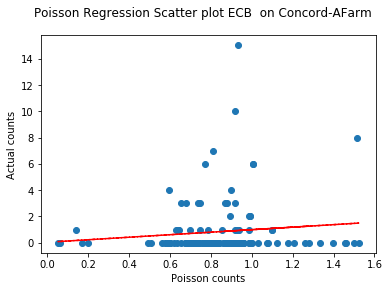

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  132
Model:                            GLM   Df Residuals:                      127
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -166.84
Date:                Tue, 12 May 2020   Deviance:                       195.84
Time:                        20:21:16   Pearson chi2:                     354.
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3034      0.928      0.327      0.744      -1.515       2.122
tempf         -0.0164      0.083     -0.196      0.8

<Figure size 432x288 with 0 Axes>

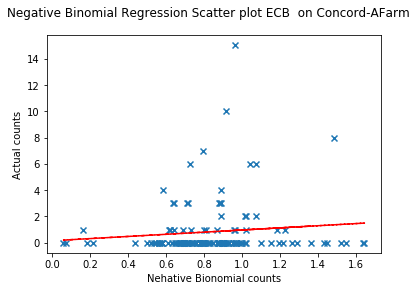

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -925.18
Date:                Tue, 12 May 2020   Deviance:                       1543.7
Time:                        20:21:17   Pearson chi2:                 1.76e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1064      0.263      8.018      0.000       1.591       2.621
tempf          0.0873      0.012      7.112      0.0

<Figure size 432x288 with 0 Axes>

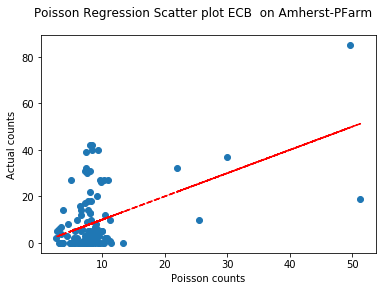

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  121
Model:                            GLM   Df Residuals:                      116
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -400.92
Date:                Tue, 12 May 2020   Deviance:                       343.90
Time:                        20:21:17   Pearson chi2:                     293.
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8995      0.607      3.131      0.002       0.710       3.089
tempf          0.0937      0.034      2.742      0.0

<Figure size 432x288 with 0 Axes>

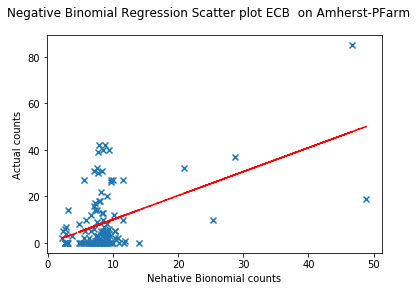

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  127
Model:                            GLM   Df Residuals:                      122
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -157.90
Date:                Tue, 12 May 2020   Deviance:                       229.15
Time:                        20:21:17   Pearson chi2:                     374.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3786      0.854     -1.615      0.106      -3.052       0.295
tempf         -0.1178      0.066     -1.785      0.0

<Figure size 432x288 with 0 Axes>

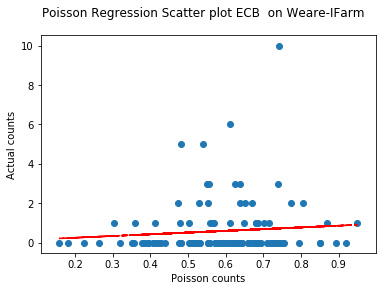

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  127
Model:                            GLM   Df Residuals:                      122
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -125.05
Date:                Tue, 12 May 2020   Deviance:                       81.780
Time:                        20:21:18   Pearson chi2:                     119.
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5693      1.512     -1.038      0.299      -4.533       1.394
tempf         -0.1494      0.104     -1.434      0.1

<Figure size 432x288 with 0 Axes>

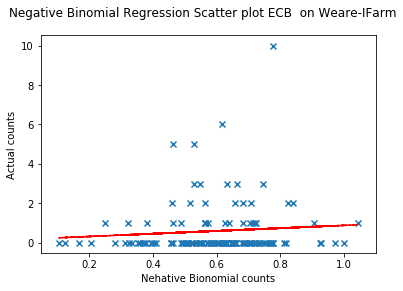

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   71
Model:                            GLM   Df Residuals:                       66
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -113.75
Date:                Tue, 12 May 2020   Deviance:                       170.02
Time:                        20:21:18   Pearson chi2:                     235.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5053      2.060     -1.702      0.089      -7.543       0.532
tempf         -0.0915      0.051     -1.778      0.0

<Figure size 432x288 with 0 Axes>

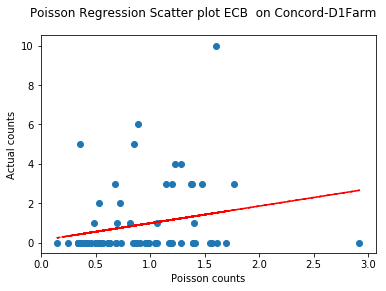

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   71
Model:                            GLM   Df Residuals:                       66
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -102.26
Date:                Tue, 12 May 2020   Deviance:                       136.81
Time:                        20:21:18   Pearson chi2:                     197.
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8774      2.266     -1.711      0.087      -8.319       0.564
tempf         -0.0844      0.057     -1.479      0.1

<Figure size 432x288 with 0 Axes>

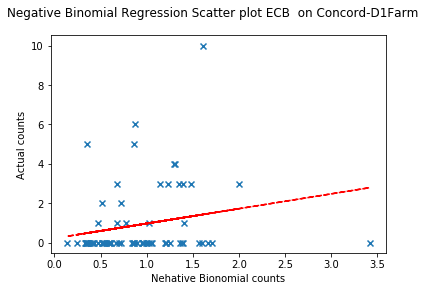

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  103
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -118.18
Date:                Tue, 12 May 2020   Deviance:                       178.85
Time:                        20:21:18   Pearson chi2:                     305.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2004      2.325     -1.377      0.169      -7.757       1.356
tempf         -0.0650      0.060     -1.077      0.2

<Figure size 432x288 with 0 Axes>

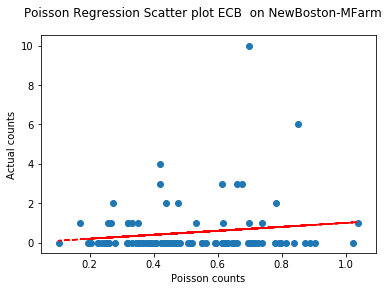

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  103
Model:                            GLM   Df Residuals:                       98
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88.747
Date:                Tue, 12 May 2020   Deviance:                       51.320
Time:                        20:21:19   Pearson chi2:                     75.5
No. Iterations:                    10   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.9953      4.330     -0.923      0.356     -12.481       4.491
tempf         -0.0445      0.118     -0.376      0.7

<Figure size 432x288 with 0 Axes>

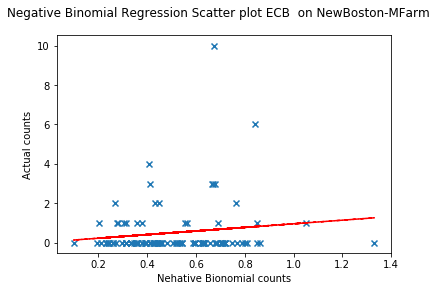

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  111
Model:                            GLM   Df Residuals:                      106
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -157.19
Date:                Tue, 12 May 2020   Deviance:                       267.68
Time:                        20:21:19   Pearson chi2:                     577.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9012      1.041      0.866      0.387      -1.139       2.941
tempf          0.1600      0.047      3.416      0.0

<Figure size 432x288 with 0 Axes>

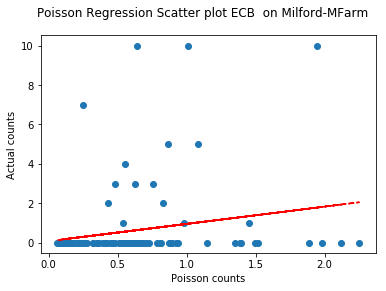

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  111
Model:                            GLM   Df Residuals:                      106
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94.225
Date:                Tue, 12 May 2020   Deviance:                       107.18
Time:                        20:21:20   Pearson chi2:                     279.
No. Iterations:                    10   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1544      1.656      0.093      0.926      -3.090       3.399
tempf          0.1829      0.077      2.361      0.0

<Figure size 432x288 with 0 Axes>

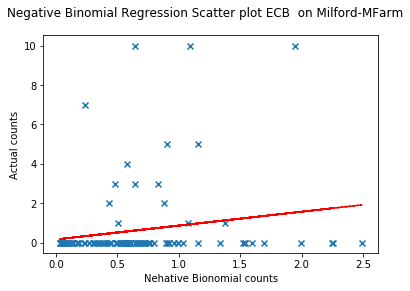

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   92
Model:                            GLM   Df Residuals:                       87
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30.178
Date:                Tue, 12 May 2020   Deviance:                       41.741
Time:                        20:21:20   Pearson chi2:                     85.3
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1725      2.453     -0.886      0.376      -6.980       2.635
tempf         -0.6600      0.750     -0.880      0.3

<Figure size 432x288 with 0 Axes>

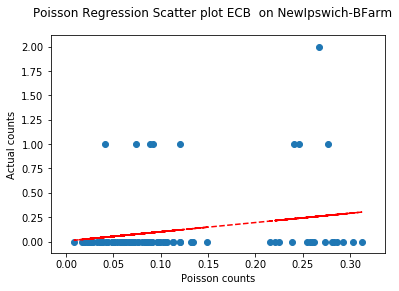

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   92
Model:                            GLM   Df Residuals:                       87
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.711
Date:                Tue, 12 May 2020   Deviance:                       3.5985
Time:                        20:21:21   Pearson chi2:                     7.75
No. Iterations:                    24   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5630      9.703     -0.367      0.713     -22.580      15.454
tempf         -1.6397      2.850     -0.575      0.5

<Figure size 432x288 with 0 Axes>

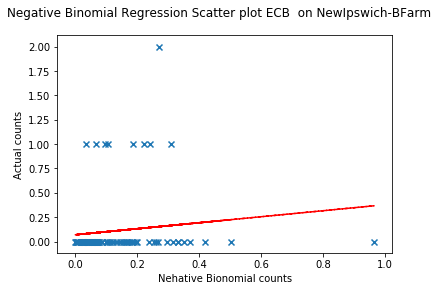

In [87]:
#creating data frame for all the pests
farm_count = 0
check = 0 
all_ECB_FARMS_DataFrame = []
compute_ECB_FARMS = []

for farm in all_ECB_FARMS:
    farmsdataframe = "df_ECB_" + farm 
    farmsdataframe = df_ECB_final.loc[df_ECB_final['farm'] == farm]
    
    count_row = farmsdataframe.shape[0]
    
    #print ((farmsdataframe['trap_count'] > 1).any())
    if (farmsdataframe['trap_count'] > 1).any() == True:
        
        #computing if there more than 50 records 
        if count_row > 50:
            
            #poission regression 
            farmsdataframe = Poisson_Regression(farmsdataframe," ECB ", farm)
            
            #negative binomial regression 
            farmsdataframe = Negative_Binomial_Regression(farmsdataframe," ECB ", farm)
        
            all_ECB_FARMS_DataFrame.append(farmsdataframe)
            
            compute_ECB_FARMS.append(farm)
        
            check = check + 1

    
    farm_count = farm_count + 1

In [88]:
#print(all_ECB_FARMS_DataFrame)
print ("check farms ", check)
print ("total farms ", farm_count)

check farms  23
total farms  53


In [89]:
len(all_ECB_FARMS_DataFrame)

23

In [90]:
len(compute_ECB_FARMS)

23

In [91]:
#valid farms used for predictions
compute_ECB_FARMS

['Litchfield-W',
 'Hollis-B',
 'Mason-B',
 'Milford-S',
 'Hollis-K',
 'Nashua-S',
 'Antrim-T',
 'Jaffrey-C',
 'Merrimack-T',
 'Pelham-G',
 'Hollis-L',
 'Litchfield-M',
 'Hudson-S',
 'Hollis-JL',
 'Milford-L',
 'Peterborough-R',
 'Concord-A',
 'Amherst-P',
 'Weare-I',
 'Concord-D1',
 'NewBoston-M',
 'Milford-M',
 'NewIpswich-B']

In [92]:
#all_ECB_FARMS_DataFrame.head()

In [93]:
all_ECB_FARMS_DataFrame[1].head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
1,Hollis-B,7,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,3,3,3,4,4
4,Hollis-B,31,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,3,3,3,5,5
7,Hollis-B,4,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,2,2,2,4,4
10,Hollis-B,0,2006,2006-07-10,71.830909,66.491782,59.745455,72.608255,3,3,3,4,5
13,Hollis-B,3,2006,2006-07-17,73.200175,66.515808,101.004367,74.150786,3,3,3,6,6


In [94]:
df_ECB_final['poisson_count_farm'] = 0
df_ECB_final['NB_count_farm'] = 0

In [95]:
#combining all the date into the main datafarme
count = 0 
for df_Farm in all_ECB_FARMS_DataFrame:
    #print (df_Farm.head()) 
    
    #getting all poission regression count 
    df_ECB_final.loc[df_ECB_final.farm == compute_ECB_FARMS[count], ['poisson_count_farm']] = df_Farm.loc[df_Farm.farm == compute_ECB_FARMS[count], ['poisson_count_farm']]
    
    #getting all negative binomial regression count 
    df_ECB_final.loc[df_ECB_final.farm == compute_ECB_FARMS[count], ['NB_count_farm']] = df_Farm.loc[df_Farm.farm == compute_ECB_FARMS[count], ['NB_count_farm']]
    
    count = count + 1
    

In [96]:
print("total farms ", count )

total farms  23


In [97]:
df_ECB_final.head(20)

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Litchfield-W,16,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,3,3,3,8,8
1,Hollis-B,7,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,3,3,3,4,4
2,Mason-B,11,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,3,3,3,2,2
3,Litchfield-W,25,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,3,3,3,7,7
4,Hollis-B,31,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,3,3,3,5,5
5,Mason-B,7,2006,2006-06-26,71.243468,65.095887,84.233871,71.733347,3,3,3,2,2
6,Litchfield-W,3,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,2,2,2,8,8
7,Hollis-B,4,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,2,2,2,4,4
8,Mason-B,1,2006,2006-07-03,71.056485,59.203758,127.515152,71.263273,2,2,2,2,2
9,Litchfield-W,12,2006,2006-07-10,71.830909,66.491782,59.745455,72.608255,3,3,3,7,7


In [98]:
df_ECB_final.tail(20)

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
4000,Milford-L,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,4,4
4001,Hollis-K,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,2,2
4002,Hollis-B,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,3,3
4003,Hollis-JL-Pl,8,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,0,0
4004,Hollis-JL-T,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,0,0
4005,Hollis-L,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,2,2
4006,Antrim-T,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,0,0
4007,Peterborough-R,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,0,0
4008,Jaffrey-C,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,1,1
4009,Mason-B,0,2018,2018-09-17,7.760753,7.281021,110.056730,7.728195,2,2,2,0,0


In [99]:
#writing into the csv file
df_ECB_final.to_csv("ECB_predicted_count.csv", index = False, sep = ',')

# Selecting weather dataframe within the date range - FAW Pest

In [100]:
print(search_faw_STdate)
print(search_faw_ENDdate)

2006-06-19 00:00:00
2018-10-15 00:00:00


In [101]:
df_equation_FAW = df_equation.loc[(df_equation['valid'] >= search_faw_STdate) & (df_equation['valid'] <= search_faw_ENDdate), :]

In [102]:
#need to get all the columns from here and sum up fro every week 
#select date and each column, and find the average for each column
df_tempf_FAW = df_equation_FAW[['tmpf','dwpf', 'drct','feel','valid']]
df_tempf_FAW["tmpf"] = df_tempf_FAW["tmpf"].fillna(0)
df_tempf_FAW["dwpf"] = df_tempf_FAW["dwpf"].fillna(0)
df_tempf_FAW["drct"] = df_tempf_FAW["drct"].fillna(0)
df_tempf_FAW["feel"] = df_tempf_FAW["feel"].fillna(0)

In [103]:
#calling getweekly_temperature
FAW_weather_data_dic = {}
getweekly_temperature(df_tempf_FAW,FAW_weather_data_dic)

total temperature index  642
total weeks:  47922


In [104]:
df_FAW_weather = pd.DataFrame(FAW_weather_data_dic)

In [105]:
#convert orginal faw date into correct dataframe date
df_FAW['date'] = df_FAW['date'].dt.date

In [106]:
#combining weather data and pest count data based on the date -----
#creating data frame needed for equation
df_FAW_weather['date'] = pd.to_datetime(df_FAW_weather['date'])
df_FAW_weather['date'] = df_FAW_weather['date'].dt.date
df_FAW_final = df_FAW.merge(df_FAW_weather, on='date')

In [107]:
df_FAW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399
4,Hollis-L,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399


# Pest Trap predictions - FAW 

In [108]:
df_FAW_final.columns

Index(['farm', 'trap_count', 'year', 'date', 'tempf', 'dwpf', 'drct', 'feel'], dtype='object')

In [109]:
df_FAW_final.describe()

,trap_count,year,tempf,dwpf,drct,feel
count,2634.000000,2634.000000,2634.000000,2634.000000,2634.000000,2634.000000
mean,2.509491,2011.413440,58.343165,51.118058,111.977890,58.283284
std,9.040741,3.469293,20.426274,17.949074,28.716146,20.552657
min,0.000000,2006.000000,6.525835,5.567537,42.116788,6.512886
25%,0.000000,2009.000000,57.474561,50.156140,91.898734,57.023889
50%,0.000000,2011.000000,66.117340,57.850297,109.006211,66.206620
75%,2.000000,2014.000000,70.040112,62.173632,130.354072,70.039030
max,190.000000,2018.000000,79.977751,68.505141,185.802469,81.125680


# 1. Multiple Linear Regression on all data 

Intercept:  2.4125366733376303
Coeffecients  [ 0.16603068 -0.2246556   0.00368826  0.02496231]
(527,)
----------- Linear Regression Evaluations------------
Mean Absolute Error (MAE):  3.681682411450239
Mean Squared Eror (MSE):  125.916631872352
Root Mean Squared Eror (RMSE):  11.221258034300432


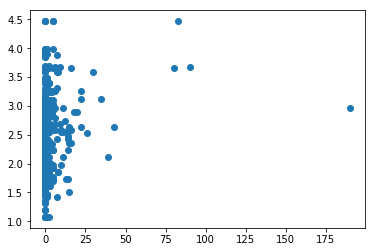

In [110]:
df_FAW_final = Multiple_Linear_Regression(df_FAW_final)

In [111]:
df_FAW_final.describe()

,trap_count,year,tempf,dwpf,drct,feel,regression_count
count,2634.000000,2634.000000,2634.000000,2634.000000,2634.000000,2634.000000,2634.000000
mean,2.509491,2011.413440,58.343165,51.118058,111.977890,58.283284,1.910402
std,9.040741,3.469293,20.426274,17.949074,28.716146,20.552657,0.693646
min,0.000000,2006.000000,6.525835,5.567537,42.116788,6.512886,1.000000
25%,0.000000,2009.000000,57.474561,50.156140,91.898734,57.023889,1.000000
50%,0.000000,2011.000000,66.117340,57.850297,109.006211,66.206620,2.000000
75%,2.000000,2014.000000,70.040112,62.173632,130.354072,70.039030,2.000000
max,190.000000,2018.000000,79.977751,68.505141,185.802469,81.125680,4.000000


# 2. Poission Regression on all data 

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2634
Model:                            GLM   Df Residuals:                     2629
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13336.
Date:                Tue, 12 May 2020   Deviance:                       23704.
Time:                        20:22:02   Pearson chi2:                 7.29e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0710      0.084     12.699      0.000       0.906       1.236
tempf          0.0774      0.011      7.154      0.0

<Figure size 432x288 with 0 Axes>

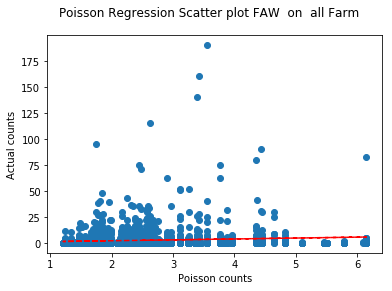

In [112]:
df_FAW_final = Poisson_Regression(df_FAW_final," FAW ", " all ")

In [113]:
df_FAW_final.head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1
4,Hollis-L,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1


# 3. Negative Binomial Regression on all data  

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                 2634
Model:                            GLM   Df Residuals:                     2629
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8083.5
Date:                Tue, 12 May 2020   Deviance:                       12540.
Time:                        20:22:02   Pearson chi2:                 4.46e+04
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0509      0.107      9.817      0.000       0.841       1.261
tempf          0.0711      0.014      5.115      0.0

<Figure size 432x288 with 0 Axes>

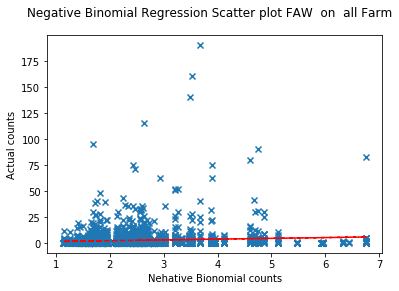

In [114]:
df_FAW_final = Negative_Binomial_Regression(df_FAW_final, " FAW ", " all ")

In [115]:
df_FAW_final

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
4,Hollis-L,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
5,Hollis-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
6,Hollis-K,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
7,Milford-S,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
8,Antrim-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1
9,Mason-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1


In [116]:
#all the farms for this pest 
all_FAW_FARMS = df_FAW_final.farm.unique()

In [117]:
all_FAW_FARMS

array(['Pelham-G', 'Litchfield-W', 'Litchfield-M', 'Merrimack-T',
       'Hollis-L', 'Hollis-B', 'Hollis-K', 'Milford-S', 'Antrim-T',
       'Mason-B', 'Peterborough-R', 'Plainfield-E', 'Milford-L',
       'NorthHaverhill-B', 'Jaffrey-C', 'Hollis-JL', 'Hudson-S',
       'Litchfield-W1', 'Merrimack-S', 'Litchfield-W2', 'Amherst-P',
       'Concord-A', 'Concord-D2', 'Concord-P', 'Loudon-P', 'Boscawen-C',
       'Weare-I', 'NewBoston-M', 'Concord-D1', 'Loudon-P1', 'Loudon-P2',
       'NewIpswich-B', 'Milford-M', 'Hollis-B2', 'Hollis-B1',
       'Bradford-W', 'NewLondon-SL', 'NorthHaverhill', 'Enfield',
       'Plainfield', 'Plymouth', 'Bristol', 'Franconia', 'Piermont',
       'Meredith-M', 'Claremont-TL', 'Hollis-JL-T', 'CenterConway-S',
       'Hollis-JL-PL', 'NewBoston-D', 'Weare-D'], dtype=object)

In [118]:
all_FAW_FARMS.shape

(51,)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  118
Model:                            GLM   Df Residuals:                      113
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -206.88
Date:                Tue, 12 May 2020   Deviance:                       322.48
Time:                        20:22:03   Pearson chi2:                     513.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8182      0.748     -2.429      0.015      -3.285      -0.351
tempf          0.0563      0.069      0.820      0.4

<Figure size 432x288 with 0 Axes>

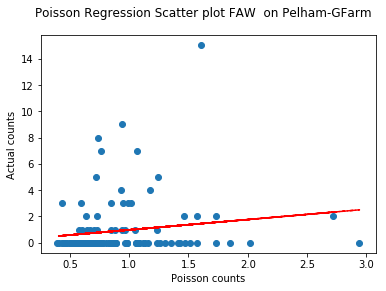

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  118
Model:                            GLM   Df Residuals:                      113
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -172.22
Date:                Tue, 12 May 2020   Deviance:                       231.96
Time:                        20:22:03   Pearson chi2:                     388.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9963      0.868     -2.299      0.022      -3.698      -0.294
tempf          0.0662      0.079      0.837      0.4

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

<Figure size 432x288 with 0 Axes>

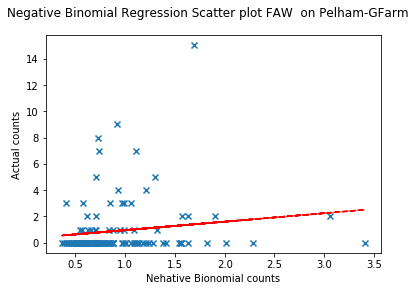

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   94
Model:                            GLM   Df Residuals:                       89
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1804.3
Date:                Tue, 12 May 2020   Deviance:                       3367.0
Time:                        20:22:03   Pearson chi2:                 5.05e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7795      0.328     17.642      0.000       5.137       6.422
tempf          0.1140      0.032      3.565      0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


<Figure size 432x288 with 0 Axes>

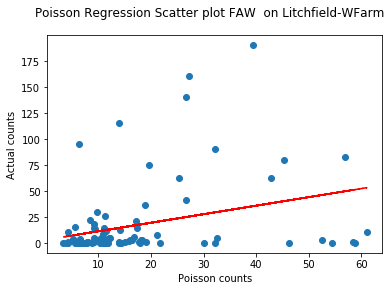

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   94
Model:                            GLM   Df Residuals:                       89
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -342.39
Date:                Tue, 12 May 2020   Deviance:                       305.96
Time:                        20:22:04   Pearson chi2:                     452.
No. Iterations:                    17   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2921      1.463      6.350      0.000       6.424      12.160
tempf         -0.0443      0.141     -0.314      0.7

<Figure size 432x288 with 0 Axes>

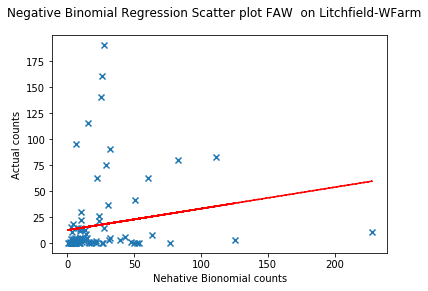

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  147
Model:                            GLM   Df Residuals:                      142
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -680.71
Date:                Tue, 12 May 2020   Deviance:                       1187.1
Time:                        20:22:04   Pearson chi2:                 2.61e+03
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2037      0.356      6.196      0.000       1.507       2.901
tempf          0.3007      0.028     10.688      0.0

<Figure size 432x288 with 0 Axes>

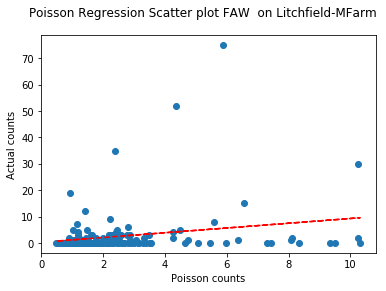

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  147
Model:                            GLM   Df Residuals:                      142
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -566.59
Date:                Tue, 12 May 2020   Deviance:                       948.52
Time:                        20:22:05   Pearson chi2:                 2.26e+03
No. Iterations:                    11   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0160      0.383      5.269      0.000       1.266       2.766
tempf          0.3111      0.031     10.195      0.0

<Figure size 432x288 with 0 Axes>

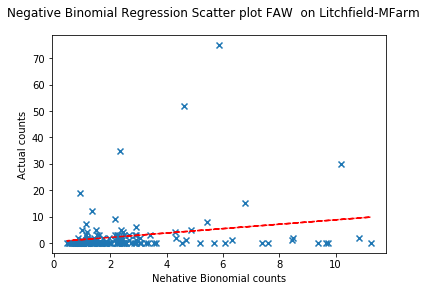

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   57
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.980
Date:                Tue, 12 May 2020   Deviance:                       26.733
Time:                        20:22:05   Pearson chi2:                     69.9
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0500      8.539      0.006      0.995     -16.687      16.787
tempf         -1.5442      1.748     -0.883      0.3

<Figure size 432x288 with 0 Axes>

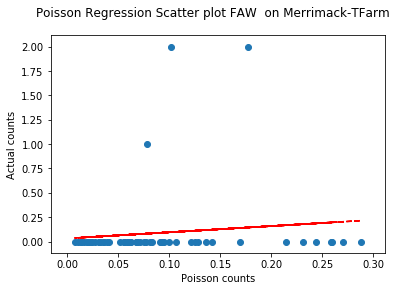

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   57
Model:                            GLM   Df Residuals:                       52
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16.730
Date:                Tue, 12 May 2020   Deviance:                       2.1422
Time:                        20:22:06   Pearson chi2:                     3.20
No. Iterations:                    34   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7674     38.058      0.572      0.567     -52.825      96.360
tempf         -7.8354      9.284     -0.844      0.3

<Figure size 432x288 with 0 Axes>

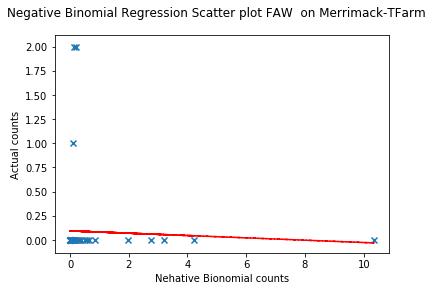

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  143
Model:                            GLM   Df Residuals:                      138
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -374.51
Date:                Tue, 12 May 2020   Deviance:                       546.34
Time:                        20:22:06   Pearson chi2:                     680.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6836      0.398     -1.719      0.086      -1.463       0.096
tempf          0.0349      0.040      0.878      0.3

<Figure size 432x288 with 0 Axes>

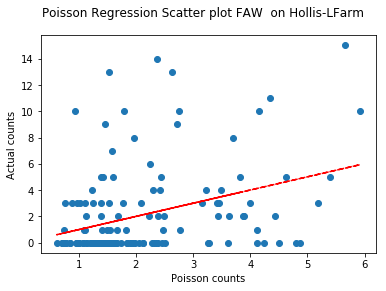

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  143
Model:                            GLM   Df Residuals:                      138
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -351.71
Date:                Tue, 12 May 2020   Deviance:                       487.60
Time:                        20:22:06   Pearson chi2:                     616.
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6225      0.425     -1.465      0.143      -1.455       0.210
tempf          0.0391      0.042      0.921      0.3

<Figure size 432x288 with 0 Axes>

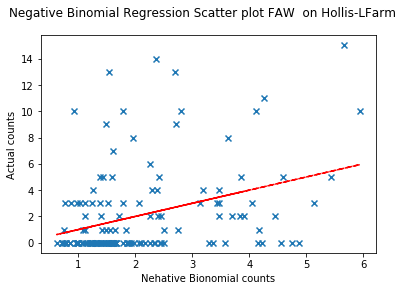

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  113
Model:                            GLM   Df Residuals:                      108
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -331.89
Date:                Tue, 12 May 2020   Deviance:                       508.51
Time:                        20:22:07   Pearson chi2:                     908.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6283      1.138      4.068      0.000       2.398       6.858
tempf         -1.0695      0.201     -5.329      0.0

<Figure size 432x288 with 0 Axes>

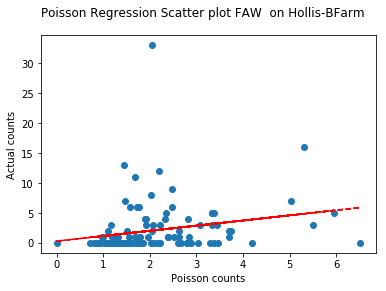

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  113
Model:                            GLM   Df Residuals:                      108
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -276.01
Date:                Tue, 12 May 2020   Deviance:                       376.14
Time:                        20:22:07   Pearson chi2:                     726.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0303      1.322      3.804      0.000       2.439       7.622
tempf         -1.1301      0.239     -4.737      0.0

<Figure size 432x288 with 0 Axes>

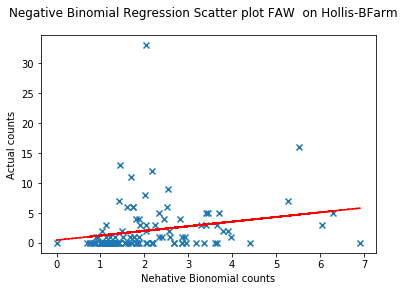

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  149
Model:                            GLM   Df Residuals:                      144
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -436.30
Date:                Tue, 12 May 2020   Deviance:                       744.33
Time:                        20:22:08   Pearson chi2:                 1.53e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3584      0.472     -2.876      0.004      -2.284      -0.433
tempf          0.1080      0.046      2.324      0.0

<Figure size 432x288 with 0 Axes>

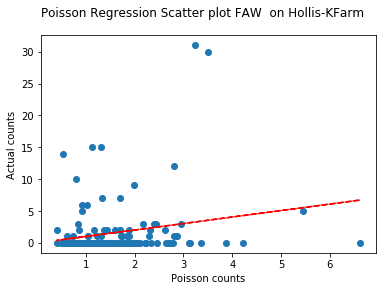

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  149
Model:                            GLM   Df Residuals:                      144
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -284.70
Date:                Tue, 12 May 2020   Deviance:                       400.40
Time:                        20:22:08   Pearson chi2:                     940.
No. Iterations:                    10   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0989      0.626     -1.755      0.079      -2.326       0.128
tempf          0.0940      0.066      1.416      0.1

<Figure size 432x288 with 0 Axes>

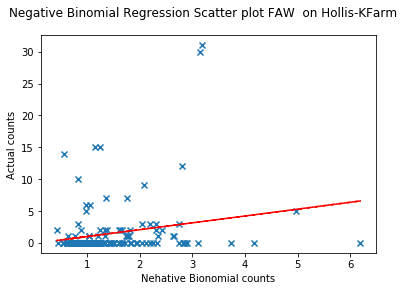

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  138
Model:                            GLM   Df Residuals:                      133
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -710.45
Date:                Tue, 12 May 2020   Deviance:                       1194.3
Time:                        20:22:08   Pearson chi2:                 1.73e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9123      0.350      5.456      0.000       1.225       2.599
tempf          0.1220      0.034      3.643      0.0

<Figure size 432x288 with 0 Axes>

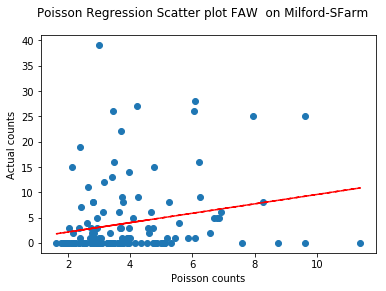

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  138
Model:                            GLM   Df Residuals:                      133
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -475.98
Date:                Tue, 12 May 2020   Deviance:                       672.97
Time:                        20:22:09   Pearson chi2:                 1.01e+03
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4569      0.472      3.086      0.002       0.532       2.382
tempf          0.1228      0.045      2.709      0.0

<Figure size 432x288 with 0 Axes>

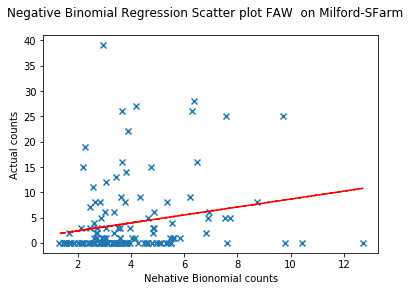

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  141
Model:                            GLM   Df Residuals:                      136
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -271.35
Date:                Tue, 12 May 2020   Deviance:                       435.65
Time:                        20:22:09   Pearson chi2:                     716.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6185      0.628     -0.985      0.325      -1.849       0.612
tempf         -0.5310      0.180     -2.954      0.0

<Figure size 432x288 with 0 Axes>

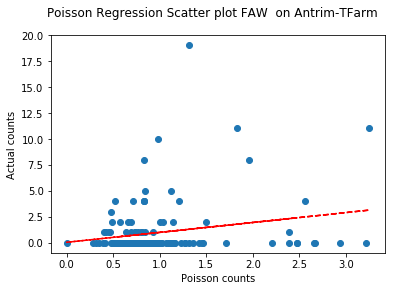

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  141
Model:                            GLM   Df Residuals:                      136
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -215.53
Date:                Tue, 12 May 2020   Deviance:                       297.15
Time:                        20:22:10   Pearson chi2:                     519.
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5431      0.737     -0.737      0.461      -1.987       0.901
tempf         -0.5660      0.207     -2.729      0.0

<Figure size 432x288 with 0 Axes>

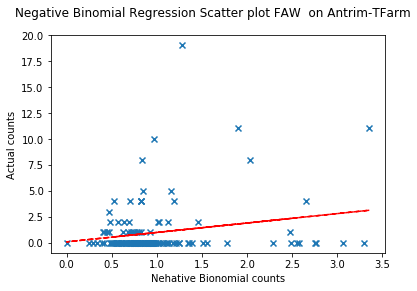

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  134
Model:                            GLM   Df Residuals:                      129
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -445.49
Date:                Tue, 12 May 2020   Deviance:                       737.87
Time:                        20:22:10   Pearson chi2:                 1.16e+03
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2172      0.446      2.732      0.006       0.344       2.090
tempf         -0.1471      0.093     -1.578      0.1

<Figure size 432x288 with 0 Axes>

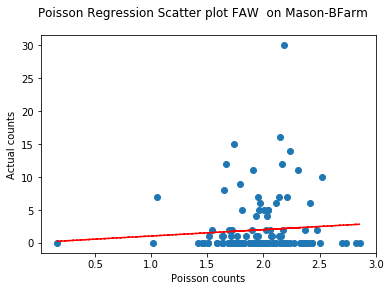

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  134
Model:                            GLM   Df Residuals:                      129
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -338.04
Date:                Tue, 12 May 2020   Deviance:                       489.88
Time:                        20:22:10   Pearson chi2:                     803.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2323      0.532      2.315      0.021       0.189       2.275
tempf         -0.1497      0.107     -1.398      0.1

<Figure size 432x288 with 0 Axes>

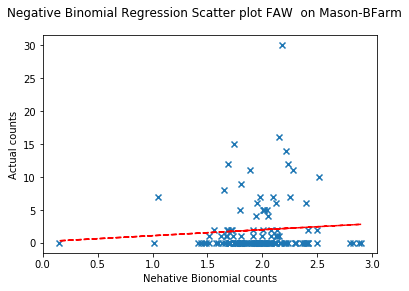

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   69
Model:                            GLM   Df Residuals:                       64
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40.180
Date:                Tue, 12 May 2020   Deviance:                       60.103
Time:                        20:22:11   Pearson chi2:                     133.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4603      2.198     -0.664      0.506      -5.768       2.847
tempf          0.5849      0.466      1.254      0.2

<Figure size 432x288 with 0 Axes>

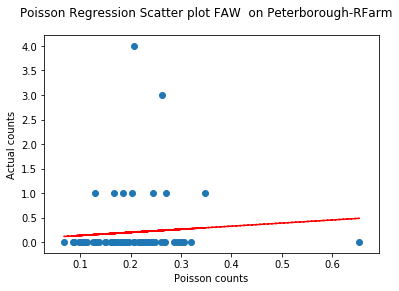

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   69
Model:                            GLM   Df Residuals:                       64
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38.988
Date:                Tue, 12 May 2020   Deviance:                       9.8065
Time:                        20:22:11   Pearson chi2:                     18.5
No. Iterations:                    15   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3106      6.189     -0.212      0.832     -13.441      10.820
tempf          1.3797      1.444      0.956      0.3

<Figure size 432x288 with 0 Axes>

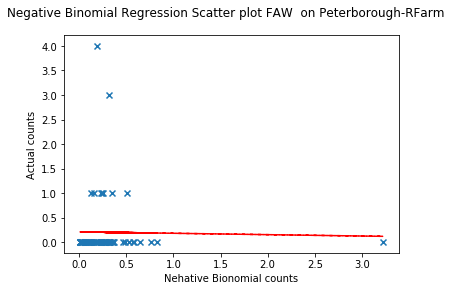

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  112
Model:                            GLM   Df Residuals:                      107
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -496.71
Date:                Tue, 12 May 2020   Deviance:                       752.09
Time:                        20:22:11   Pearson chi2:                     867.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0603      0.308      0.196      0.845      -0.544       0.665
tempf          0.0047      0.076      0.062      0.9

<Figure size 432x288 with 0 Axes>

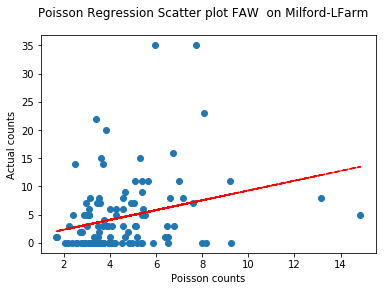

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  112
Model:                            GLM   Df Residuals:                      107
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -333.90
Date:                Tue, 12 May 2020   Deviance:                       356.47
Time:                        20:22:12   Pearson chi2:                     371.
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1717      0.475      0.362      0.718      -0.759       1.103
tempf          0.0120      0.120      0.100      0.9

<Figure size 432x288 with 0 Axes>

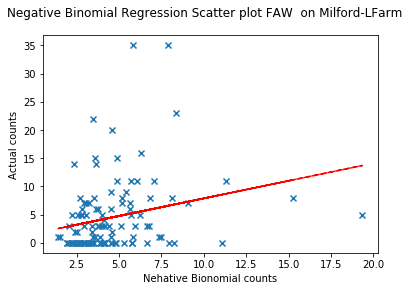

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  126
Model:                            GLM   Df Residuals:                      121
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -285.36
Date:                Tue, 12 May 2020   Deviance:                       468.90
Time:                        20:22:12   Pearson chi2:                     762.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5735      0.668     -3.852      0.000      -3.883      -1.264
tempf          0.0677      0.053      1.269      0.2

<Figure size 432x288 with 0 Axes>

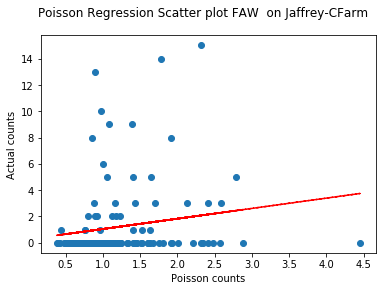

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  126
Model:                            GLM   Df Residuals:                      121
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -212.05
Date:                Tue, 12 May 2020   Deviance:                       290.74
Time:                        20:22:12   Pearson chi2:                     509.
No. Iterations:                     9   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9216      0.844     -3.460      0.001      -4.577      -1.267
tempf          0.1049      0.068      1.554      0.1

<Figure size 432x288 with 0 Axes>

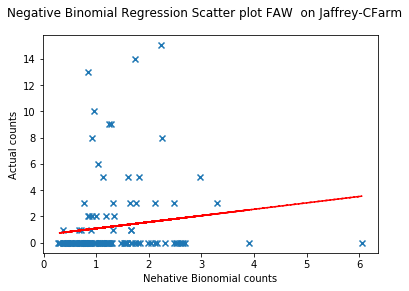

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  114
Model:                            GLM   Df Residuals:                      109
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -443.97
Date:                Tue, 12 May 2020   Deviance:                       764.37
Time:                        20:22:13   Pearson chi2:                 1.44e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1784      1.111      7.363      0.000       6.001      10.355
tempf         -0.6472      0.206     -3.141      0.0

<Figure size 432x288 with 0 Axes>

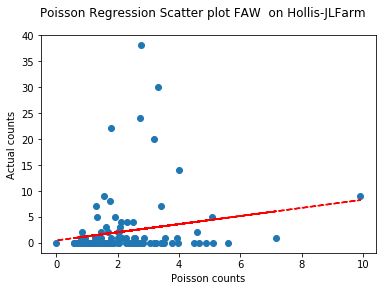

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  114
Model:                            GLM   Df Residuals:                      109
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -407.81
Date:                Tue, 12 May 2020   Deviance:                       686.81
Time:                        20:22:13   Pearson chi2:                 1.35e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4483      1.158      7.293      0.000       6.178      10.719
tempf         -0.6811      0.213     -3.199      0.0

<Figure size 432x288 with 0 Axes>

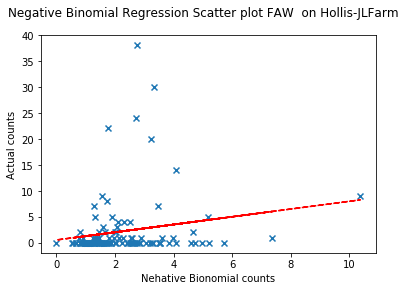

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  124
Model:                            GLM   Df Residuals:                      119
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -132.53
Date:                Tue, 12 May 2020   Deviance:                       183.19
Time:                        20:22:13   Pearson chi2:                     251.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0874      0.904     -0.097      0.923      -1.860       1.685
tempf          0.0860      0.131      0.658      0.5

<Figure size 432x288 with 0 Axes>

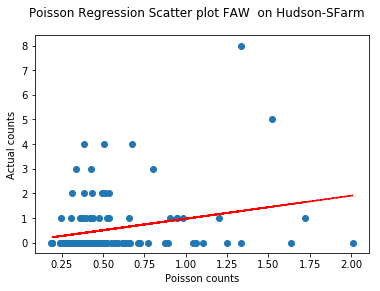

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                  124
Model:                            GLM   Df Residuals:                      119
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -115.25
Date:                Tue, 12 May 2020   Deviance:                       104.35
Time:                        20:22:14   Pearson chi2:                     142.
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2767      1.204      0.230      0.818      -2.083       2.636
tempf          0.0599      0.184      0.325      0.7

<Figure size 432x288 with 0 Axes>

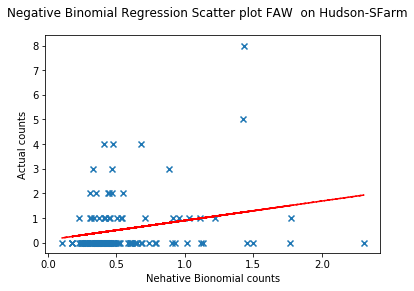

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   55
Model:                            GLM   Df Residuals:                       50
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60.862
Date:                Tue, 12 May 2020   Deviance:                       89.568
Time:                        20:22:14   Pearson chi2:                     128.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1420      1.576     -1.359      0.174      -5.232       0.947
tempf          0.0721      0.140      0.516      0.6

<Figure size 432x288 with 0 Axes>

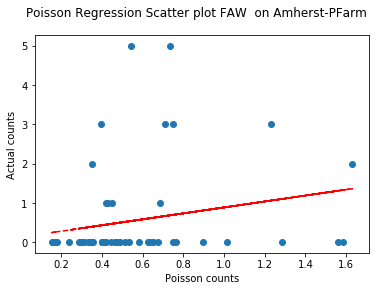

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   55
Model:                            GLM   Df Residuals:                       50
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.677
Date:                Tue, 12 May 2020   Deviance:                       35.159
Time:                        20:22:15   Pearson chi2:                     51.3
No. Iterations:                    12   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8081      2.662     -0.679      0.497      -7.025       3.409
tempf          0.1055      0.250      0.422      0.6

<Figure size 432x288 with 0 Axes>

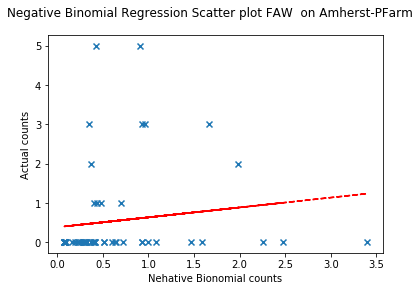

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   77
Model:                            GLM   Df Residuals:                       72
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -250.67
Date:                Tue, 12 May 2020   Deviance:                       403.69
Time:                        20:22:15   Pearson chi2:                     508.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4520      0.527      2.753      0.006       0.418       2.486
tempf         -0.0196      0.067     -0.292      0.7

<Figure size 432x288 with 0 Axes>

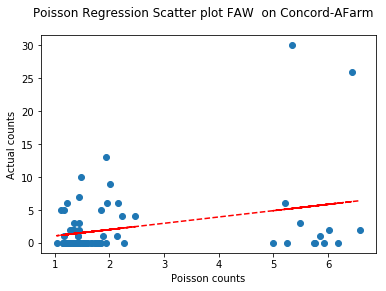

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   77
Model:                            GLM   Df Residuals:                       72
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -184.88
Date:                Tue, 12 May 2020   Deviance:                       251.20
Time:                        20:22:16   Pearson chi2:                     310.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4164      0.658      2.152      0.031       0.127       2.706
tempf         -0.0329      0.080     -0.410      0.6

<Figure size 432x288 with 0 Axes>

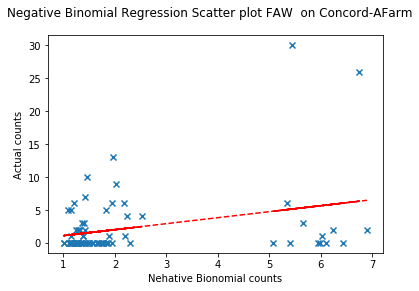

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   73
Model:                            GLM   Df Residuals:                       68
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.659
Date:                Tue, 12 May 2020   Deviance:                       69.729
Time:                        20:22:16   Pearson chi2:                     115.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1524      1.477      0.103      0.918      -2.742       3.047
tempf         -0.4336      0.510     -0.850      0.3

<Figure size 432x288 with 0 Axes>

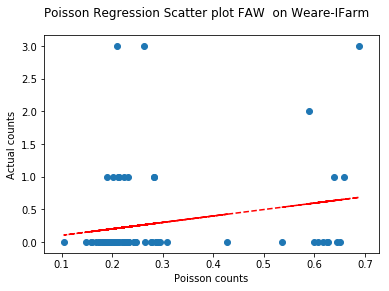

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   73
Model:                            GLM   Df Residuals:                       68
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -56.326
Date:                Tue, 12 May 2020   Deviance:                       13.058
Time:                        20:22:16   Pearson chi2:                     17.2
No. Iterations:                    27   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0731      4.056     -0.018      0.986      -8.024       7.877
tempf         -0.9489      1.370     -0.693      0.4

<Figure size 432x288 with 0 Axes>

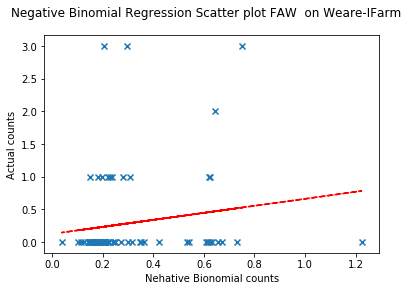

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   53
Model:                            GLM   Df Residuals:                       48
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -75.694
Date:                Tue, 12 May 2020   Deviance:                       112.99
Time:                        20:22:17   Pearson chi2:                     150.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0573      2.601      5.021      0.000       7.960      18.155
tempf         -0.1021      0.241     -0.423      0.6

<Figure size 432x288 with 0 Axes>

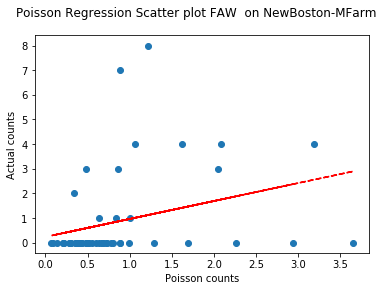

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   53
Model:                            GLM   Df Residuals:                       48
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -56.892
Date:                Tue, 12 May 2020   Deviance:                       54.370
Time:                        20:22:17   Pearson chi2:                     66.5
No. Iterations:                    13   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.2126      4.531      4.461      0.000      11.331      29.094
tempf         -0.2330      0.471     -0.494      0.6

<Figure size 432x288 with 0 Axes>

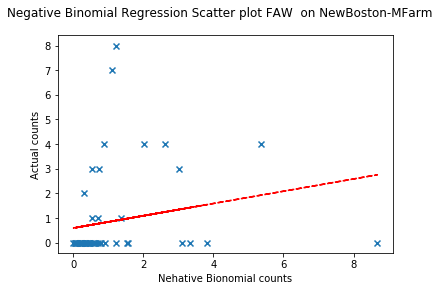

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   56
Model:                            GLM   Df Residuals:                       51
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -83.837
Date:                Tue, 12 May 2020   Deviance:                       136.55
Time:                        20:22:17   Pearson chi2:                     258.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8301      1.275     -1.436      0.151      -4.328       0.668
tempf         -0.5822      0.479     -1.217      0.2

<Figure size 432x288 with 0 Axes>

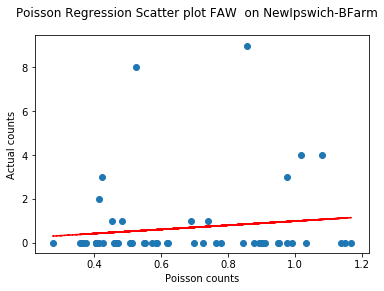

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   56
Model:                            GLM   Df Residuals:                       51
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61.240
Date:                Tue, 12 May 2020   Deviance:                       76.111
Time:                        20:22:18   Pearson chi2:                     158.
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8277      1.622     -1.127      0.260      -5.007       1.352
tempf         -0.6085      0.601     -1.013      0.3

<Figure size 432x288 with 0 Axes>

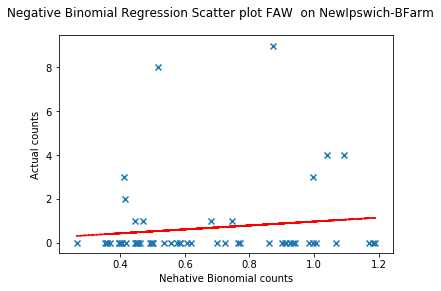

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -128.99
Date:                Tue, 12 May 2020   Deviance:                       196.35
Time:                        20:22:18   Pearson chi2:                     261.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2642      0.801      1.579      0.114      -0.305       2.834
tempf          0.0878      0.201      0.438      0.6

<Figure size 432x288 with 0 Axes>

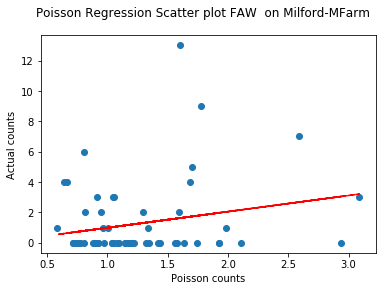

                 Generalized Linear Model Regression Results                  
Dep. Variable:             trap_count   No. Observations:                   62
Model:                            GLM   Df Residuals:                       57
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -98.898
Date:                Tue, 12 May 2020   Deviance:                       112.79
Time:                        20:22:19   Pearson chi2:                     152.
No. Iterations:                    10   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0648      1.062      1.003      0.316      -1.016       3.146
tempf          0.0893      0.284      0.314      0.7

<Figure size 432x288 with 0 Axes>

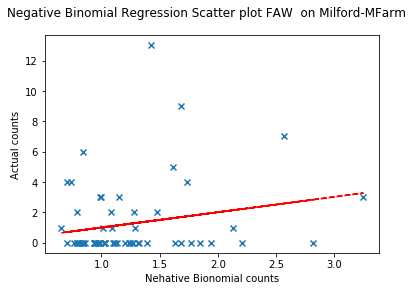

In [119]:
#computing pest counts for all the dataframes 
farm_count = 0
all_FAW_FARMS_DataFrame = []
compute_FAW_FARMS = []

for farm in all_FAW_FARMS:
    farmsdataframe = "df_FAW_" + farm 
    farmsdataframe = df_FAW_final.loc[df_FAW_final['farm'] == farm]
    
    count_row = farmsdataframe.shape[0]
    
    #print ((farmsdataframe['trap_count'] > 1).any())
    if (farmsdataframe['trap_count'] > 1).any() == True:
        
        #computing if there more than 50 records 
        if count_row > 50:
            
            #Poission Regression 
            farmsdataframe = Poisson_Regression(farmsdataframe," FAW ", farm)
            
            #Negative Binomial Regression 
            farmsdataframe = Negative_Binomial_Regression(farmsdataframe," FAW ", farm)
        
            all_FAW_FARMS_DataFrame.append(farmsdataframe)
            
            compute_FAW_FARMS.append(farm)
        
            farm_count = farm_count + 1

In [120]:
print ("total farms ", farm_count)

total farms  21


In [121]:
len(all_FAW_FARMS_DataFrame)

21

In [122]:
len(compute_FAW_FARMS)

21

In [123]:
#all the farms used for predictions 
compute_FAW_FARMS

['Pelham-G',
 'Litchfield-W',
 'Litchfield-M',
 'Merrimack-T',
 'Hollis-L',
 'Hollis-B',
 'Hollis-K',
 'Milford-S',
 'Antrim-T',
 'Mason-B',
 'Peterborough-R',
 'Milford-L',
 'Jaffrey-C',
 'Hollis-JL',
 'Hudson-S',
 'Amherst-P',
 'Concord-A',
 'Weare-I',
 'NewBoston-M',
 'NewIpswich-B',
 'Milford-M']

In [124]:
all_FAW_FARMS_DataFrame[13].head()

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
194,Hollis-JL,0,2007,2007-07-09,66.428494,61.414903,88.803089,66.624054,1,1,1,1,1
206,Hollis-JL,0,2007,2007-07-16,67.757217,60.901565,118.956522,67.763739,2,1,1,0,0
220,Hollis-JL,0,2007,2007-07-23,71.214553,64.778979,58.978723,71.808383,1,1,1,2,2
234,Hollis-JL,0,2007,2007-07-30,74.360971,64.758058,88.689320,75.193447,2,2,2,2,2
248,Hollis-JL,0,2007,2007-08-06,67.766345,61.987550,99.236948,68.019076,1,1,1,1,1


In [125]:
df_FAW_final['poisson_count_farm'] = 0
df_FAW_final['NB_count_farm'] = 0

In [126]:
#combining all the pest counts for final data frame
count = 0 
for df_Farm in all_FAW_FARMS_DataFrame:
    #print (df_Farm.head())
    #print(count)
    
    #getting all poission regression count 
    df_FAW_final.loc[df_FAW_final.farm == compute_FAW_FARMS[count], ['poisson_count_farm']] = df_Farm.loc[df_Farm.farm == compute_FAW_FARMS[count], ['poisson_count_farm']]
    
    #getting all negative binomial regression count 
    df_FAW_final.loc[df_FAW_final.farm == compute_FAW_FARMS[count], ['NB_count_farm']] = df_Farm.loc[df_Farm.farm == compute_FAW_FARMS[count], ['NB_count_farm']]
    
    count = count + 1

In [127]:
print(count)

21


In [128]:
df_FAW_final.head(20)

,farm,trap_count,year,date,tempf,dwpf,drct,feel,regression_count,poisson_count,NB_count,poisson_count_farm,NB_count_farm
0,Pelham-G,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,0,0
1,Litchfield-W,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,10,4
2,Litchfield-M,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,1,1
3,Merrimack-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,0,0
4,Hollis-L,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,0,0
5,Hollis-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,0,0
6,Hollis-K,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,0,0
7,Milford-S,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,4,4
8,Antrim-T,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,0,0
9,Mason-B,0,2006,2006-06-19,70.977613,63.913169,63.703704,71.301399,1,1,1,2,2


In [129]:
#writing into the csv file
df_FAW_final.to_csv("FAW_predicted_count.csv", index = False, sep = ',')